In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import numpy as np
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import math

# River chemistry data for the pan-Arctic. Part I: ArcticGRO data

Aim: have monthly mean chemistry for big suite of chemical variables required by marine modellers, for all RADR catchments + Greenland, for the period 1980-2019

Approach:

**1. Big 6 rivers: base on observed data from ArcticGRO (this notebook)**

* Quick plot of time series to see how long the record is, gaps, etc. in each river
* Derive regressions with Q:
    * For the three sites where chemistry is measured a long way away from discharge, adjust the datetime by offsetting, so that the new timestamp matches the day when discharge is measured
    * For each chem variable, and for a variety of temporal aggregations (e.g. daily, monthly):
        * Plot QC
        * Plot logQ-logC
        * Fit linear regression. How good is regression?
    * Use regressions with Q to derive daily or monthly concentration in each river for full baseline period.
 * For DON, predict using DOC rather than Q
 * For some species, there was no relationship with Q, so constant concentrations are assumed (P species).

**To do still:**

- I jumped straight into QC regressions, as these are needed for the first half of the study period. However, for the period with chem data, perhaps converting to monthly frequency and interpolating is better? Interpolating daily data didn't work well, but monthly might be better. Try this, as some of the predictions look rubbish for some rivers. Requires low variability in river water chemistry, so that the single sample taken per month (or so) is roughly representative of that month, and for peak flows to be captured. To take into account when doing this: nice plot on ArcticGRO website of when samples were taken relative to Q (so I don't need to re-do it). Can see that e.g. Ob and Yukon, sampling captured peak flows and baseflows nicely all years up to end of 2019 (and to end 2022 for Ob). So a good argument for interpolating at Ob', especially as CQ relationships were most dodgy here. Update: had a go at this, but I'm actually a bit suspicious about step changes in some of the observed data. Think I'll stick to CQ for now.
- Work on DOC regressions more. Log-log CQ is not great for Lena, Yukon and especially the Mackenzie. For these, there appears to be a constant concentration in baseflow and then an increase as Q increases. Could e.g. split by season (winter vs rest of year).
- R2 for fitted models apply to log-log transformed data. Need to also look at R2, bias, etc. of predictions (with bias-adjusted backtransform).
- Look more at Hg. Here there is data for UTHg. There is supposed to be UMeHg data (plot of the data is available online), but sheet is empty. Emailed 2022-12-01 to ask about this and Fe data; no reply yet. **Update: apparently there were QC issues with the UMeHg data, so it can't be used. There is no Fe data.**
- If DIC is of interest, could look into calculating from Alk and pH data. Though there isn't much pH data compared to other variables, and the data there is looks a little dodgy. Would also have to make some assumptions about lab temperature, as this isn't reported I don't think (think the Temp variable is in situ temperature). To make this calc, see this useful-looking python package https://pyco2sys.readthedocs.io/en/latest/
- Some of the variables look like they have trends. E.g. SiO2 has been decreasing all over since around 2016. Try to take this into account? Is SiO2 important in any of the marine models?
- Future improvement: cleaned Q data has been truncated to the end of 2019 (modelling period). But for deriving regressions would be good to include all the available chem data, i.e. to the end of 2020. So make 2 versions of the Q data, or just have the cleaned Q data to the end of 2020 instead. However, ArcticGRO chem data for 2020 is still absent or preliminary, so this is just a future improvement.

Then in future notebooks:

**2. Predict water quality in the rest of the largely unmonitored AO**
* Lit review. Catchment characteristics.
* Focus in particular on DOC, DIC??, Hg. Rest can be based on same methods used in A20 hindcast Andre and Phil did.

## User input

In [2]:
# Location of cleaned discharge data
q_cleaned_daily_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_daily'
q_cleaned_monthly_folder = r'~/shared/pan_arctic_data/discharge/ArcticGRO/data/cleaned_monthly'

# Location of chem data and associated units info
in_chem_file = r'~/shared/pan_arctic_data/water_quality/ArcticGRO/ArcticGRO Water Quality Data_2022-02.xlsx'
chem_units_fpath = r'~/shared/pan_arctic_data/water_quality/ArcticGRO/ArcticGRO_original_chem_units.csv'

# Location of df defining start and end day of year (integer) of open water season (cols: river, start, end)
define_season_df_fpath = r'../output/define_q_season_df.csv'

# Folders to store output
out_folder_joined_cq = r'../output/joined_cq_obs'
out_folder_qc = r'../output/predicted_arcticgro_chem/diagnostics/qc_regressions'
out_folder_predictions = r'../output/predicted_arcticgro_chem/predictions'
out_folder_predictions_timeseries_daily = r'../output/predicted_arcticgro_chem/diagnostics/timeseries/daily'
out_folder_predictions_timeseries_monthly = r'../output/predicted_arcticgro_chem/diagnostics/timeseries/monthly'

season_thresh_df = pd.read_csv(define_season_df_fpath, index_col=0)

## Read in chem data and associated metadata and convert units to mg/l

In [3]:
original_units_df = pd.read_csv(chem_units_fpath, index_col=0)
original_units_df

Description  Unit
Var                                                          
Alk                            Alkalinity as mg CaCO3/L  mg/L
DOC                            Dissolved organic carbon  mg/L
DON                          Dissolved organic nitrogen  mg/L
NO3                                    Nitrate-nitrogen  µg/L
NH4                                   Ammonium-nitrogen  µg/L
TDP                          Total dissolved phosphorus  µg/L
PO4                Soluble reactive phosphorus (~PO4-P)  µg/L
DHP   Dissolved hydrolysable phosphorus (~dissolved ...  µg/L
SiO2                              Silicate as mg SiO2/L  mg/L
UTHg                           Unfiltered total mercury  ng/L
POC                          Particulate organic carbon  mg/L
PON                        Particulate organic nitrogen  µg/L

In [4]:
transform_units_li = []
for var in original_units_df.index:
    if original_units_df.loc[var, "Unit"] == "µg/L":
        transform_units_li.append(var)
transform_units_li

['NO3', 'NH4', 'TDP', 'PO4', 'DHP', 'PON']

In [5]:
xl = pd.ExcelFile(in_chem_file)
rivers_li = xl.sheet_names[:-1]
rivers_li

['Ob', 'Yenisey', 'Lena', 'Kolyma', 'Yukon', 'Mackenzie']

In [6]:
chem_dict = {}  # key: river name (from rivers_li)

for river in rivers_li:
    df = pd.read_excel(in_chem_file, sheet_name=river, header=8, index_col=2,
                       skiprows=[9], parse_dates=True)

    # Convert vars in units of ug/l to mg/l. Then all apart from Hg are in
    # units of mg/l. Hg is ng/L
    for var in df.columns:
        if var in transform_units_li:
            df[var] = df[var].copy()/1000

    # Calculate DON (mg/l) and add to dataframe
    df['DON'] = df['TDN'] - (df['NO3'] + df['NH4'])
    df.loc[df['DON'] < 0, 'DON'] = 0  # set any negative values to 0

    # Calculate DHP (dissolved hydrolysable P)
    df['DHP'] = df['TDP'] - df['PO4']
    df.loc[df['DHP'] < 0, 'DHP'] = 0  # set any negative values to 0

    # Add DOC:x mass ratios and fix divide by zero issues
    df['DOC_DON'] = df['DOC']/df['DON']
    df.loc[~np.isfinite(df['DOC_DON']), 'DOC_DON'] = np.nan

    # Add x:DOC ratios
    for var in ['TDP', 'DHP', 'UTHg']:
        df['%s_DOC' % var] = df[var]/df['DOC']
        df.loc[~np.isfinite(df['%s_DOC' % var]), '%s_DOC' % var] = np.nan

    chem_dict[river] = df

chem_dict['Ob'].head()

Phase River   ID  Discharge  Temp   pH  Cond    Alk  A254  \
Date                                                                       
2003-07-16  PARTNERS   Ob'  NaN    31200.0  19.8  7.5   NaN   44.9   NaN   
2004-04-05  PARTNERS   Ob'  NaN     3553.0  -1.0  7.0   NaN  130.6   NaN   
2004-06-15  PARTNERS   Ob'  NaN    34500.0  10.5  7.7   NaN   32.9   NaN   
2004-06-17  PARTNERS   Ob'  NaN    34500.0  12.6  7.7   NaN   34.4   NaN   
2004-07-28  PARTNERS   Ob'  NaN    26000.0  20.0  7.5   NaN   38.4   NaN   

            A375  ...  POC (2)  POC-13C (2)  PON (2)  PON-15N (2)      DON  \
Date              ...                                                        
2003-07-16   NaN  ...      NaN          NaN      NaN          NaN  0.35812   
2004-04-05   NaN  ...      NaN          NaN      NaN          NaN  0.10139   
2004-06-15   NaN  ...      NaN          NaN      NaN          NaN  0.23439   
2004-06-17   NaN  ...      NaN          NaN      NaN          NaN  0.20965   
2004-07-28   NaN  ...      NaN          NaN      NaN          NaN  0.42492   

            DHP    DOC_DON   TDP_DOC  DHP_DOC  UTHg_DOC  
Date                                                     
2003-07-16  NaN  30.660114  0.005446      NaN       NaN  
2004-04-05  NaN  54.245981  0.002771      NaN       NaN  
2004-06-15  NaN  37.160288  0.003395      NaN       NaN  
2004-06-17  NaN  41.545433  0.003395      NaN       NaN  
2004-07-28  NaN  28.264144  0.004357      NaN       NaN  

[5 rows x 65 columns]

In [7]:
chem_dict['Ob'].columns

Index(['Phase', 'River', 'ID', 'Discharge', 'Temp', 'pH', 'Cond', 'Alk',
       'A254', 'A375', 'A412', 'A420', 'A440', 'H2O-2H', 'H2O-18O', 'DOC',
       'DOC-13C', 'DOC-14C', 'DOC-fm', 'TDN', 'NO3', 'NH4', 'TDP', 'PO4',
       'SiO2', 'Na', 'K', 'Mg', 'Ca', 'As', 'Ba', 'Cl', 'SO4', 'Li', 'Rb',
       'Sr', 'U', 'F', 'UTHg', 'UMeHg', 'TSS', 'POC', 'POC-13C', 'POC-14C',
       'POC-fm', 'PON', 'PON-15N', 'Sample depth 1', 'TSS (1)', 'POC (1)',
       'POC-13C (1)', 'PON (1)', 'PON-15N (1)', 'Sample depth 2', 'TSS (2)',
       'POC (2)', 'POC-13C (2)', 'PON (2)', 'PON-15N (2)', 'DON', 'DHP',
       'DOC_DON', 'TDP_DOC', 'DHP_DOC', 'UTHg_DOC'],
      dtype='object')

# Read in discharge data

In [8]:
q_dict = {}

for river in rivers_li:
    fpath = os.path.join(q_cleaned_daily_folder, "%s_daily_1980-2019.csv" % river)
    q_df = pd.read_csv(fpath, index_col=0, parse_dates=True)
    q_dict[river] = q_df

q_dict['Ob'].head()

discharge
date                 
1980-01-01     7360.0
1980-01-02     7350.0
1980-01-03     7350.0
1980-01-04     7320.0
1980-01-05     7290.0

# Make dataset including chem and Q

To do this, first need to apply date offset to get chem data as seen at discharge stations. 3 rivers monitor discharge and chemistry in different places, so following method used by Holmes et al. (): Calculate lag time between the two sampling stations by assuming river velocities of 1.5 m/s. Therefore use measured concentrations and assume they were observed at downstream locations on day + lag. Work out lags to apply as follows:
* Lena: water chem is 520 m U/S of discharge. Lag of ~4 days. Add 4 days to the WQ dates.
* Yenisey: WQ is 250 km D/S of Q. Lag of ~-2 days. Subtract 2 days.
* Kolyma: WQ is 150 km D/S of Q. Lag of ~-1 day. Subtract 1 day.

Also add discharge data for sampling dates. The ArcticGRO water quality data includes discharge data already. This is usually the same as the ArcticGRO discharge data for the same date, but not always. Perhaps it is because of the data cleaning I did, or patching, or perhaps they made errors too. Either way, I will use my cleaned data as the basis, rather than the discharge data included with the chem data.

Also truncate to just the chem variables of interest.

In [9]:
# Have replaced TDN with DON, as TDN didn't show a relationship with Q
chem_vars = [
    "pH",
    "Alk",
    "DOC",
    "DON",
    "DOC_DON",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
    "DHP",
    "TDP_DOC",
    "DHP_DOC",
    "UTHg_DOC",
]

lag_dict = {"Lena": 4, "Yenisey": -2, "Kolyma": -1}

chem_q_daily_dict = {}
chem_q_monthly_dict = {}

for river in rivers_li:
    chem_df = chem_dict[river].copy()

    # Drop unwanted cols
    chem_df = chem_df.loc[:, chem_vars]

    # Convert to daily frequency, in prep for time shift for some rivs, and converting
    # to monthly freq for all
    chem_df_daily = chem_df.asfreq("D")
    chem_df_daily = chem_df_daily.loc[:"2019-12-31"]  # Truncate to period of interest

    # For some rivs, apply time shift so chem dates are on the day at which that water parcel
    # would be seen at the gauging station ('ish)
    if river in lag_dict.keys():
        chem_df_daily = chem_df_daily.shift(lag_dict[river])

    # Add discharge data to the chem data (from cleaned ArcticGRO discharge files,
    # rather than using the 'Discharge' column in the WQ data)
    chem_df_daily["Q"] = q_dict[river].loc[chem_df_daily.index]

    # Also calculate monthly mean discharge and chem
    chem_df_monthly = chem_df_daily.resample("M").agg(np.mean)

    # Drop rows where all are NaNs (i.e. drop the daily or monthly freq)
    # chem_df_daily.dropna(subset=chem_df_daily.columns.difference(['Q']),
    #                      how="all", inplace=True)
    # chem_df_monthly.dropna(subset=chem_df_monthly.columns.difference(['Q']),
    #                        how="all", inplace=True)

    # Add to dicts
    chem_q_daily_dict[river] = chem_df_daily
    chem_q_monthly_dict[river] = chem_df_monthly

    # Save csvs, dropping NaNs first
    chem_df_daily.dropna(
        subset=chem_df_daily.columns.difference(["Q"]), how="all", inplace=False
    ).to_csv(os.path.join(out_folder_joined_cq, "daily", "cq_obs_daily_%s.csv" % river))

    chem_df_monthly.dropna(
        subset=chem_df_monthly.columns.difference(["Q"]), how="all", inplace=False
    ).to_csv(os.path.join(out_folder_joined_cq, "monthly_mean", "cq_obs_monthly_%s.csv" % river))

# Check at Lena. DOC was 5.2 on 2003-08-12. Should now be 5.2 on 2003-08-16. Ok
print("Check of offset at Lena:")
print(chem_q_daily_dict["Lena"]["DOC"].head())

# Check new Q column is ok. Find: identical for US rivs, bit diff for Sib ones.
# So code is working ok.
# print(chem_q_daily_dict['Mackenzie'].loc[:, ['Discharge', 'Q']])
print("\n" "Check of daily data for Ob:")
print(chem_q_daily_dict["Ob"].head())

print("\n" "Check of monthly data for Ob:")
print(chem_q_monthly_dict["Ob"].head())

Check of offset at Lena:
Date
2003-08-12    NaN
2003-08-13    NaN
2003-08-14    NaN
2003-08-15    NaN
2003-08-16    5.2
Freq: D, Name: DOC, dtype: float64

Check of daily data for Ob:
             pH   Alk    DOC      DON    DOC_DON      NO3      NH4     TDP  \
Date                                                                         
2003-07-16  7.5  44.9  10.98  0.35812  30.660114  0.04902  0.04286  0.0598   
2003-07-17  NaN   NaN    NaN      NaN        NaN      NaN      NaN     NaN   
2003-07-18  NaN   NaN    NaN      NaN        NaN      NaN      NaN     NaN   
2003-07-19  NaN   NaN    NaN      NaN        NaN      NaN      NaN     NaN   
2003-07-20  NaN   NaN    NaN      NaN        NaN      NaN      NaN     NaN   

            PO4  SiO2  UTHg   POC      PON  DHP   TDP_DOC  DHP_DOC  UTHg_DOC  \
Date                                                                           
2003-07-16  NaN  3.86   NaN  1.23  0.14007  NaN  0.005446      NaN       NaN   
2003-07-17  NaN   NaN   NaN  

# Explore CQ relationships

## Time series

In [10]:
# Function to plot time series of chem and Q together for each river
def plot_timeseries(chem_var, rivers_li, chem_dict, q_dict):

    for river in rivers_li:

        fig = plt.figure(figsize=(10, 3))

        # Plot chem data
        ax = fig.add_subplot()
        chem_df = chem_dict[river][chem_var]
        chem_df.plot(marker='o', color='k', linestyle='none', grid=True, ax=ax)
        ax.set_ylabel(chem_var)
        ax.set_xlabel("")
        ax.legend('Chem', loc='upper left')

        # Plot Q data
        ax2 = ax.twinx()
        q_df = q_dict[river]['Q'].loc['2003-01-01':]
        q_df.plot(ax=ax2)
        ax2.set_ylabel('Q')
        ax2.legend('Q', loc='upper right')

        # Tidy
        plt.title("%s" % str(river))
        plt.tight_layout()
        plt.show()

        plt.savefig(os.path.join(out_folder_qc, 'timeseries', 'q-chem',
                                 'timeseries_q_chem_%s_%s' % (chem_var, river)))

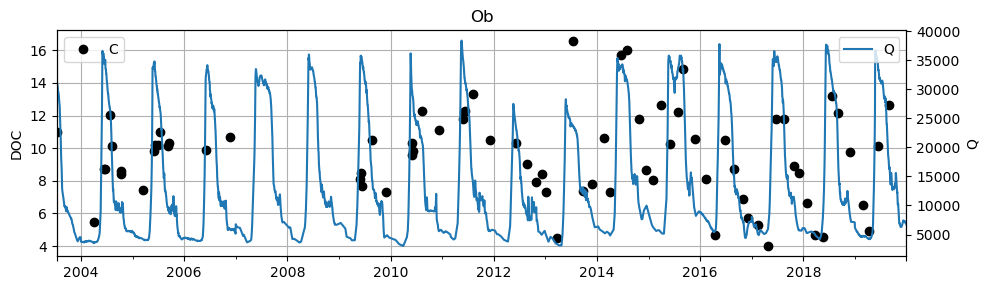

<Figure size 640x480 with 0 Axes>

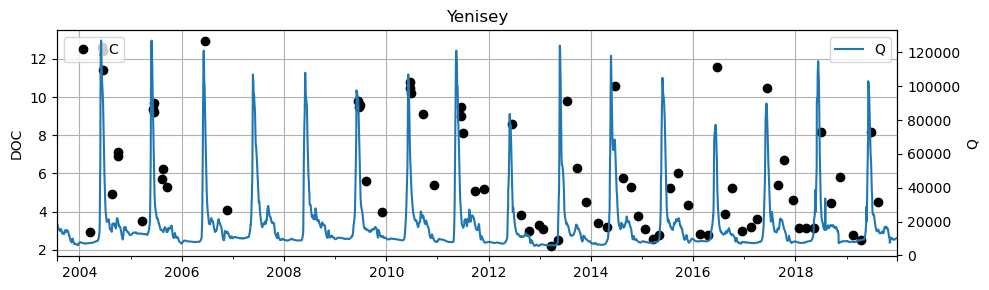

<Figure size 640x480 with 0 Axes>

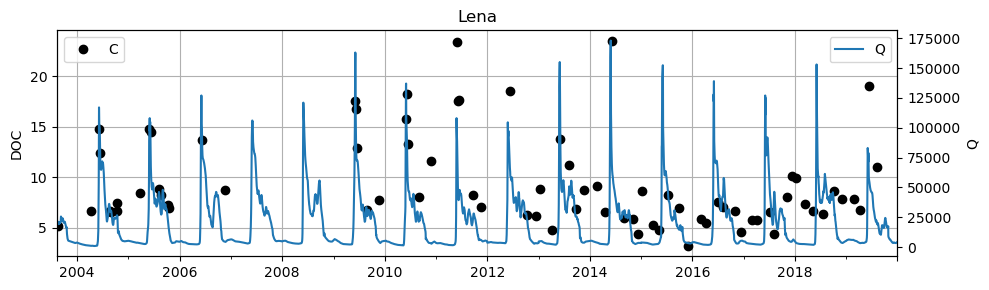

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

<Figure size 640x480 with 0 Axes>

In [11]:
q_df = plot_timeseries('DOC', rivers_li, chem_q_daily_dict, chem_q_daily_dict)

In [12]:
# plot_timeseries('pH', rivers_li, chem_dict, q_dict)

## Chem vs Q

In [15]:
def split_df_by_season(df, season_thresh_df, river):
    df['doy'] = df.index.day_of_year
    wint_mask = df['doy'].between(season_thresh_df.loc[river]['start'],
                                  season_thresh_df.loc[river]['end'])
    df_wint = df.mask(wint_mask)
    df_summ = df.mask(~wint_mask)

    return(df_wint, df_summ)


def q_c_linear_regression(chem_q_dict, chem_var, out_folder_qc,
                          log_q=False, log_chem=False, season_split=False,
                          monthly=False):
    """
    """

    fig, axs = plt.subplots(nrows=1, ncols=len(rivers_li),
                            sharex=False, sharey=False, figsize=(17, 3))
    axs = axs.flatten()

    fig2, axs2 = plt.subplots(nrows=1, ncols=len(rivers_li),
                              sharex=False, sharey=False, figsize=(17, 3))
    axs2 = axs2.flatten()

    reg_dict = {}  # Key: river, season. Returns sklearn linear regression model
    alpha_df = pd.DataFrame(columns=['river', 'chem_var', 'season', 'alpha'])
    stats_df = pd.DataFrame(columns=['chem_var', 'river', 'season', 'r_sq', 'rmse', 'bias'])

    for i, river in enumerate(rivers_li):
        df = chem_q_dict[river].loc[:, ["Q", chem_var]]
        df = df.dropna()
        if len(df) < 20:
            print("%s: Not enough data to derive CQ relationship" % river)
            continue

        # If desired, log transform the data first
        if log_q is True:
            df["Q"] = np.log10(df["Q"])
            xlabel = "Log10 Q"
        else:
            xlabel = "Q"

        if log_chem is True:
            # To avoid log(0) errors, replace zeros with a small value
            # (1/200 of the mean). Or NaN
            # sub_value = df[chem_var].mean()/200
            n_zeros = df.loc[df[chem_var] == 0, chem_var].count()
            if n_zeros >= 1:
                print("%s, n zeros in %s = %s. Replaced with NaNs" % (river, chem_var, n_zeros))
            sub_value = np.NaN
            df.loc[df[chem_var] == 0, chem_var] = sub_value
            df = df.dropna()
            # Then work out log
            df[chem_var] = np.log10(df[chem_var])
            # And set how the y-axis label will look
            ylabel = "Log10 %s" % chem_var
        else:
            ylabel = chem_var

        if season_split is True:
            df_wint, df_summ = split_df_by_season(df, season_thresh_df, river)
            df_dict = {'winter': df_wint, 'summer': df_summ}
        else:
            df_dict = {'annual': df}

        # Fit regression
        for season in df_dict.keys():
            df = df_dict[season]
            df = df.dropna()
            x = df["Q"].values.reshape((-1, 1))
            y = df[chem_var].values

            model = LinearRegression().fit(x, y)
            y_pred = model.predict(x)
            residuals = (y - y_pred)

            # To bias correct when back-transforming, calculate alpha
            # Only need this when log-transformed
            alpha = np.exp(2.651*((residuals)**2).mean())
            alpha_df.loc[len(alpha_df)] = [river, chem_var, season, alpha]
            # alpha_df.loc[river, season] = alpha
            # alpha_s.name = chem_var

            # Save regression model in a dict
            reg_dict[(river, season)] = model

            # Calculate and save model performance stats
            r_sq = model.score(x, y)
            rmse = mean_squared_error(y, y_pred, squared=False)
            bias = np.mean(residuals)
            # bias = np.mean(y) - np.mean(y_pred)
            stats_df.loc[len(stats_df)] = [chem_var, river, season, r_sq, rmse, bias]

            # Plot output of linear regression

            # CQ plot
            marker_color_dict = {'annual': 'blue', 'summer': 'orange', 'winter': 'blue'}
            line_color_dict = {'annual': 'darkblue', 'summer': 'brown', 'winter': 'darkblue'}
            axs[i].scatter(x, y, color=marker_color_dict[season])
            axs[i].plot(x, y_pred, color=line_color_dict[season], linewidth=2)
            axs[i].set_xlabel(xlabel)
            if i == 0:
                axs[i].set_ylabel(ylabel)
            axs[i].set_title(river)

            # Residuals vs Q
            axs2[i].scatter(x, residuals, color=marker_color_dict[season],
                            label='residuals')
            axs2[i].axhline(0, color='black')
            axs2[i].set_label(xlabel)
            if i == 0:
                axs2[i].set_ylabel("%s, obs-sim" % ylabel)
            axs2[i].set_title(river)

    # Sort out file names and save
    if monthly is True:
        freq_str = "monthly"
    else:
        freq_str = "daily"

    # linear_reg_df.to_csv(
    #     os.path.join(
    #         out_folder_qc,
    #         "qc_regression_%s_%s_logq-%s_logchem_%s.csv"
    #         % (chem_var, freq_str, log_q, log_chem),
    #     ),
    #     index_label="River",
    # )

    fig.tight_layout()
    fig.savefig(
        os.path.join(
            out_folder_qc,
            'scatterplots',
            "qc_scatter_%s_%s_logq-%s_logchem_%s_season-split_%s.png"
            % (chem_var, freq_str, log_q, log_chem, season_split),
        )
    )

    fig2.tight_layout()
    fig2.savefig(
        os.path.join(
            out_folder_qc,
            'scatterplots',
            "cq_residuals_%s_%s_logq-%s_logchem_%s_season-split_%s.png"
            % (chem_var, freq_str, log_q, log_chem, season_split),
        )
    )
    plt.close(fig2)  # Don't display this figure, just save it

    # print(linear_reg_df)
    return (reg_dict, alpha_df, stats_df)

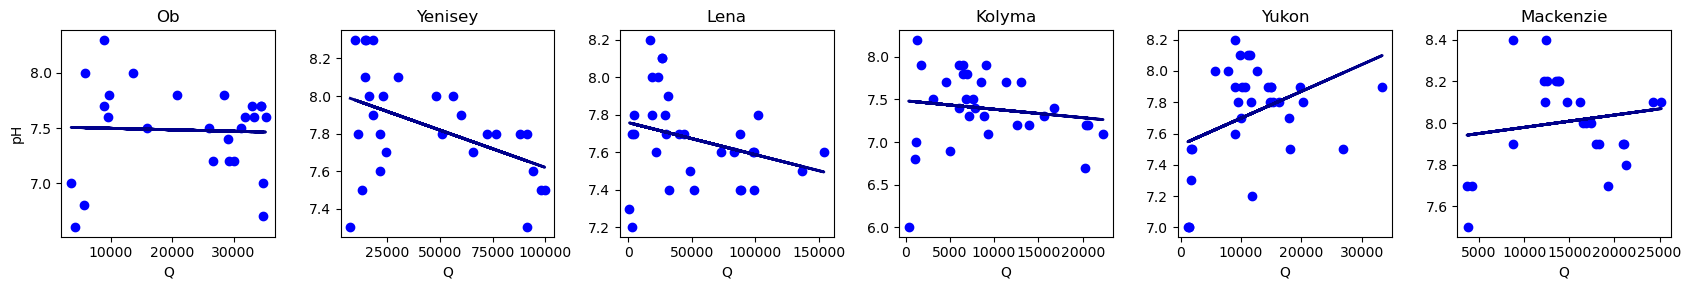

In [18]:
# Testing out for just one variable: Linear regression, pH
reg_dict, alpha_df, stats_df = q_c_linear_regression(chem_q_daily_dict, 'pH',
                                                     out_folder_qc, season_split=False)

In [17]:
# Testing out for just one variable: Log-log regression, DOC
reg_dict, alphas, stats_df = q_c_linear_regression(chem_q_daily_dict, 'DOC',
                                                   out_folder_qc, log_chem=True,
                                                   log_q=True, season_split=False)

**Some comments:**
* pH: Lowest values are during lowest flows. Odd, I would have thought this was groundwater. But then pH tends to increase as Q increases from very low to low flow. And then from low to high flow, there is a decrease in pH (Ob, Yenisey, Kolyma, Mackenzie), so that the highest Qs have the same low pH as the lowest flows. Elsewhere, there is not much change (Lena) or maybe even an increase (Yukon).
* DOC: Log-log looks better than linear. See pretty distinct seasonal clouds. Whether these should be joined to one another or whether independent lines should be fit within each is a classical statistical conundrum.

### CQ regression, all rivs and vars, no seasonal split

Ob, n zeros in DON = 1. Replaced with NaNs
Yukon, n zeros in DON = 2. Replaced with NaNs
Ob, n zeros in NO3 = 3. Replaced with NaNs
Yenisey, n zeros in NO3 = 2. Replaced with NaNs
Lena, n zeros in NO3 = 2. Replaced with NaNs
Kolyma, n zeros in NO3 = 1. Replaced with NaNs
Ob, n zeros in NH4 = 5. Replaced with NaNs
Yenisey, n zeros in NH4 = 15. Replaced with NaNs
Lena, n zeros in NH4 = 8. Replaced with NaNs
Kolyma, n zeros in NH4 = 7. Replaced with NaNs
Yukon, n zeros in NH4 = 2. Replaced with NaNs
Mackenzie, n zeros in NH4 = 13. Replaced with NaNs
Ob, n zeros in DHP = 4. Replaced with NaNs
Yenisey, n zeros in DHP = 15. Replaced with NaNs
Lena, n zeros in DHP = 13. Replaced with NaNs
Kolyma, n zeros in DHP = 11. Replaced with NaNs
Yukon, n zeros in DHP = 9. Replaced with NaNs
Mackenzie, n zeros in DHP = 1. Replaced with NaNs


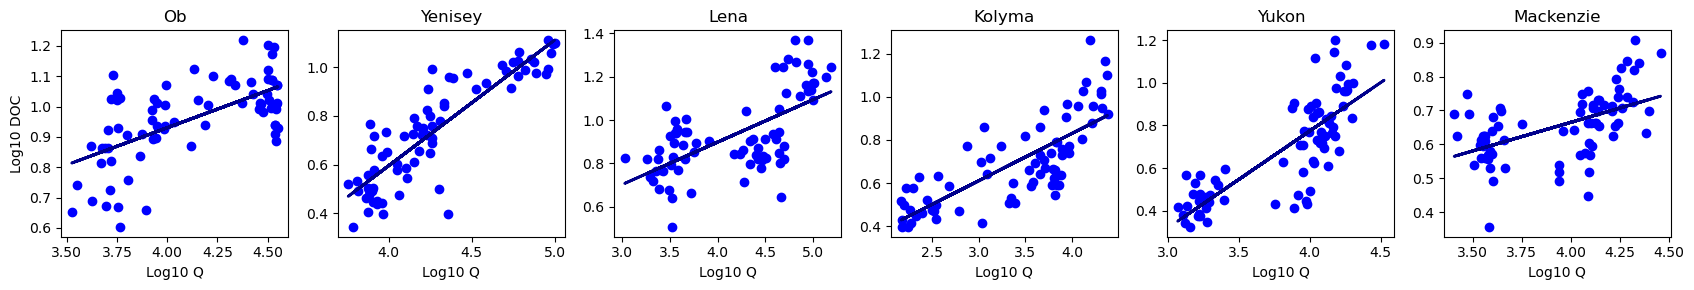

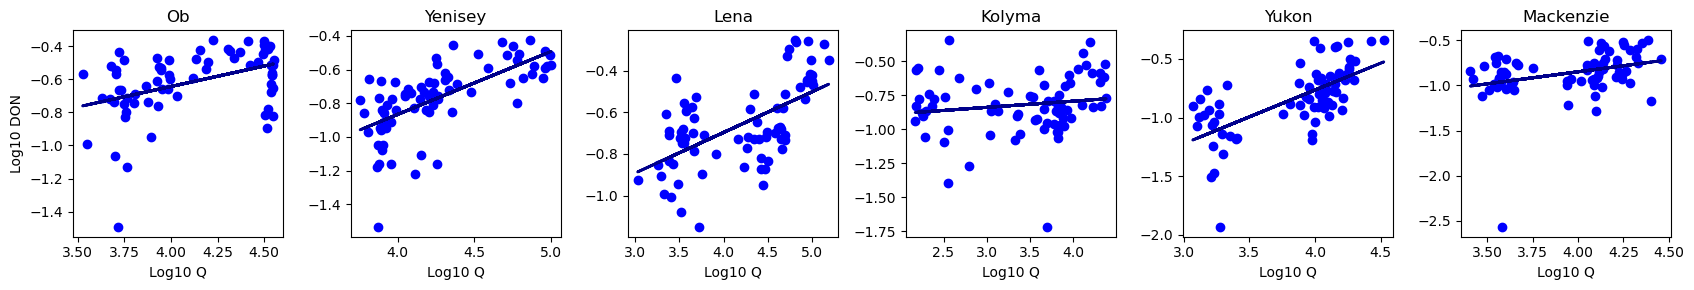

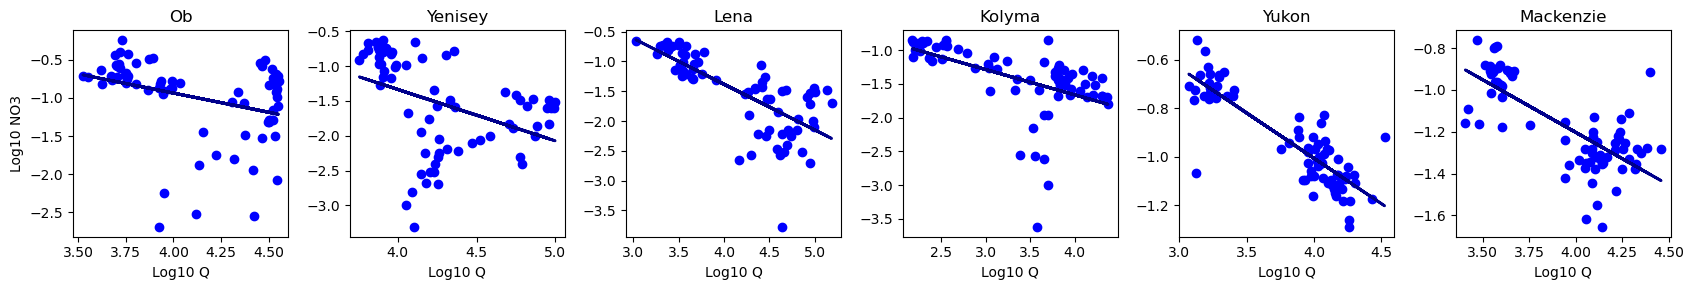

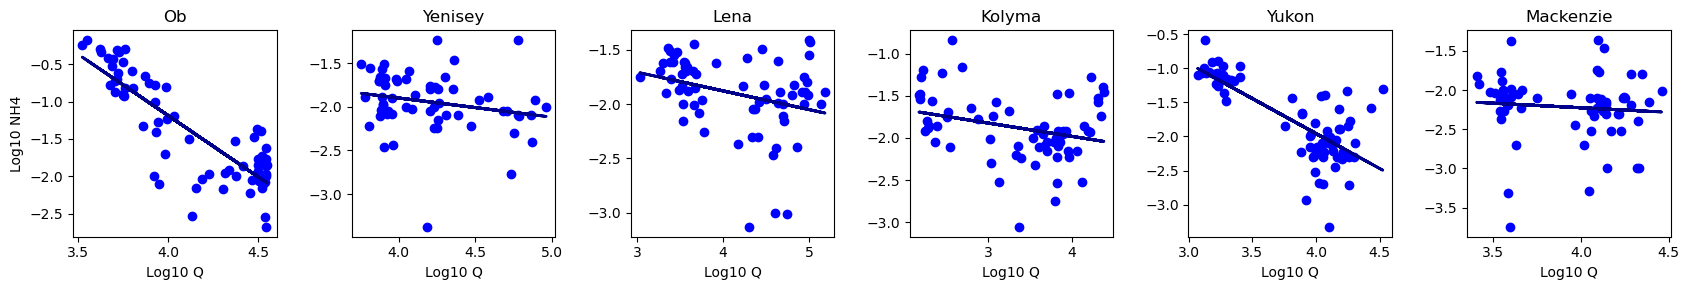

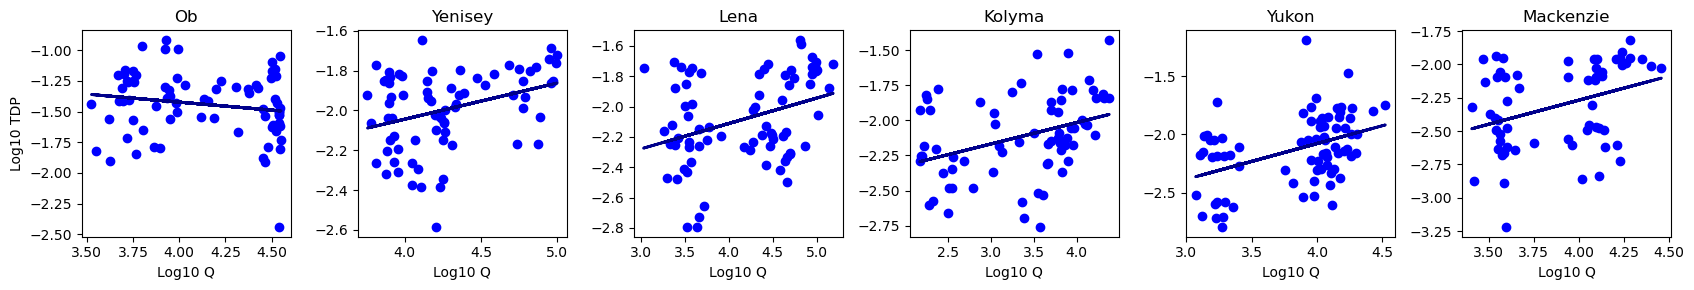

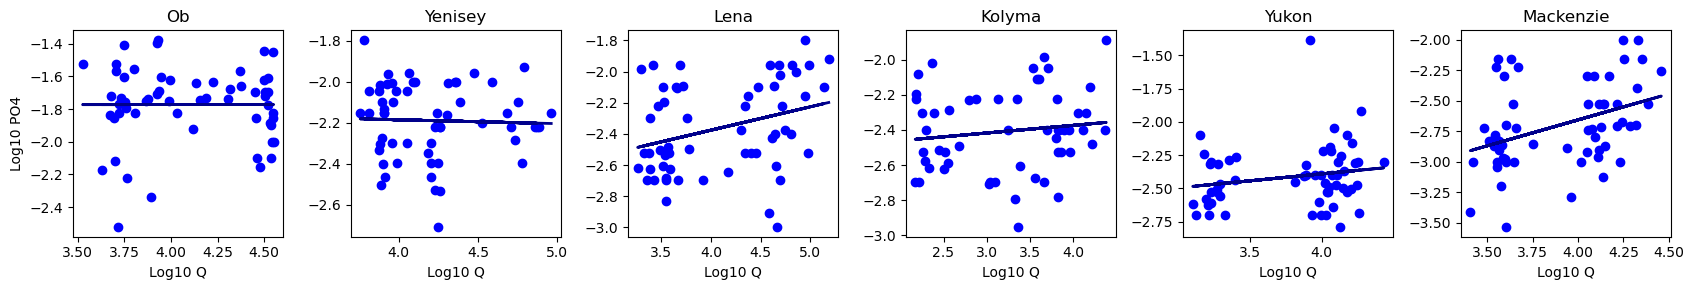

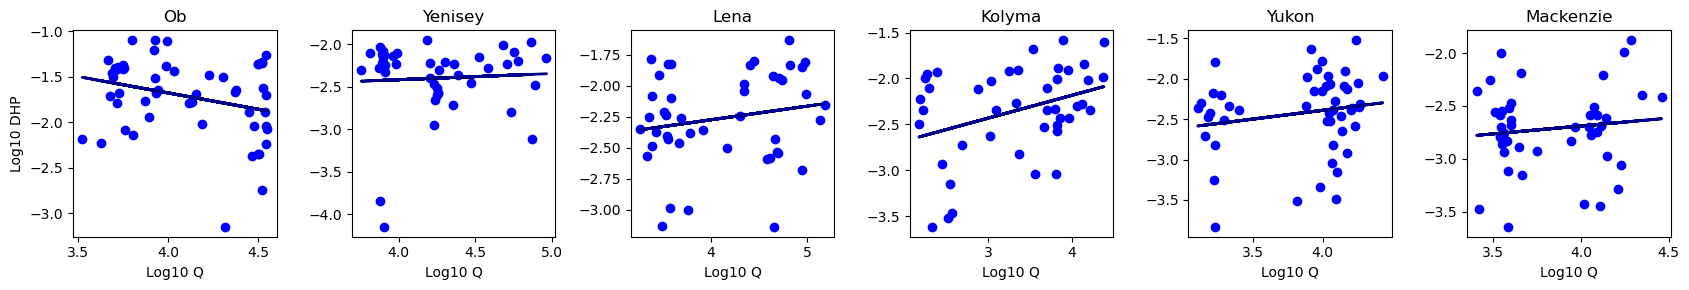

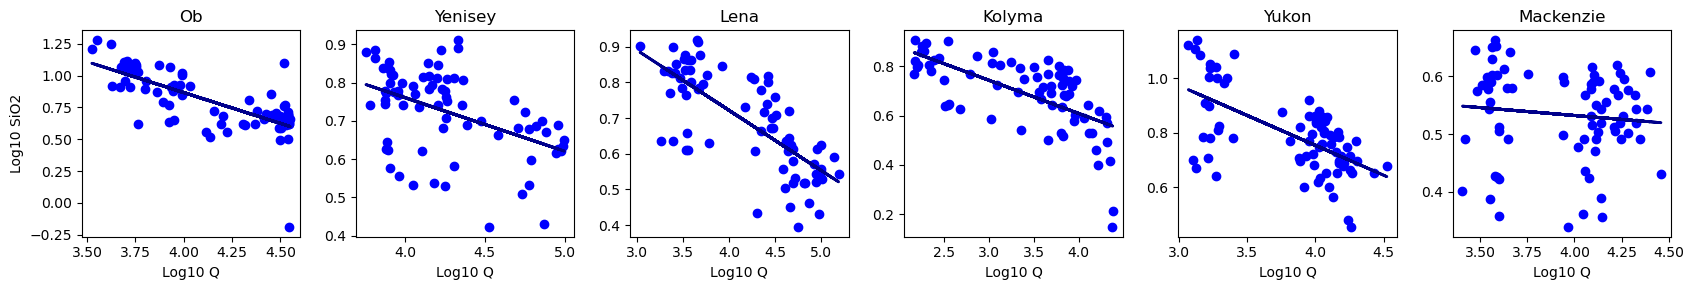

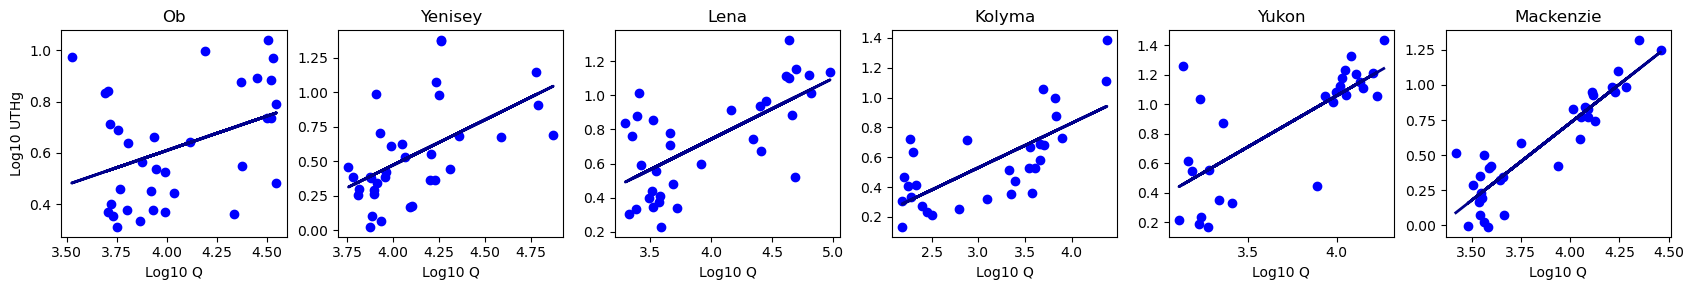

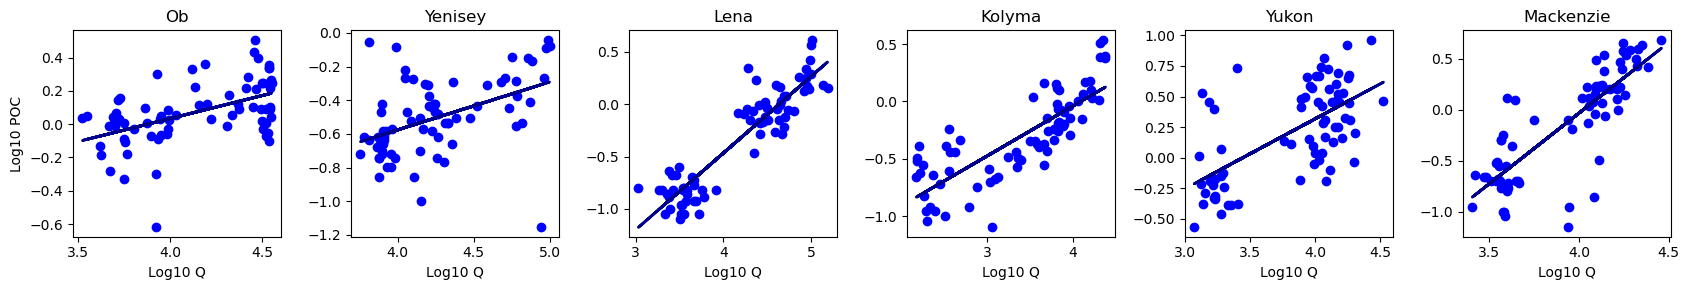

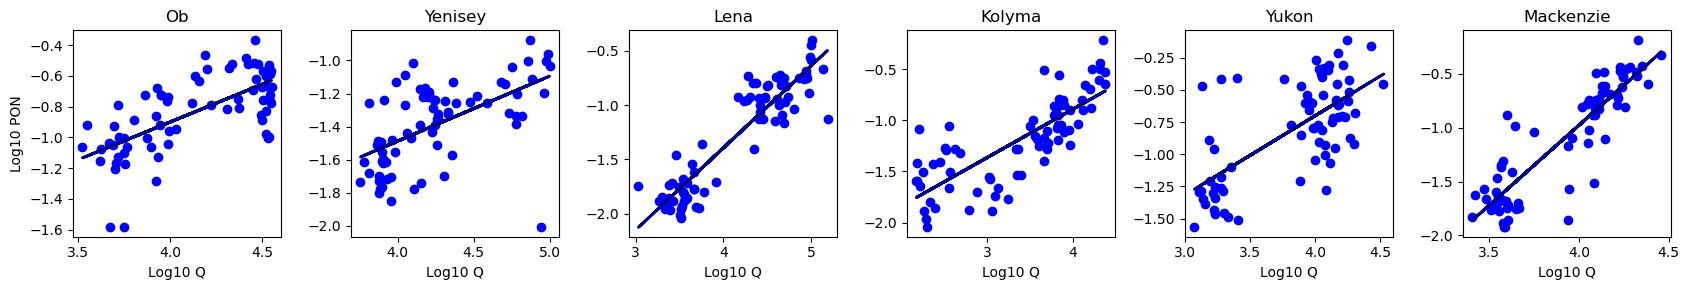

In [19]:
chem_vars_cq = [
    "pH",
    "Alk",
    "DOC",
    "DON",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "DHP",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
]

# Key: chem_var, returns dict with key river, which in turn returns regression model
reg_dict_untransf = {}
reg_dict_log = {}

stats_li = []
alphas_li = []

for chem_var in chem_vars_cq:
    reg_dict_log[(chem_var, 'annual')], alphas, stats = q_c_linear_regression(
        chem_q_daily_dict, chem_var, out_folder_qc, log_chem=True, log_q=True
    )

    stats_li.append(stats)
    alphas_li.append(alphas)

    # reg_dict_untransf[chem_var] = q_c_linear_regression(chem_q_daily_dict,
    #                                                     chem_var,
    #                                                     out_folder_qc,
    #                                                     log_chem=False,
    #                                                     log_q=False)
    # q_c_linear_regression(chem_q_monthly_dict, chem_var, out_folder_qc, monthly=True)

stats_df = pd.concat(stats_li, axis=0)
alpha_df = pd.concat(alphas_li, axis=0)

### CQ regression, all rivs & vars, split by season

**To do still:** More tweaks to seasonal split of data so it matches reality better

In [25]:
season_thresh_df = pd.read_csv(define_season_df_fpath, index_col=0)
season_thresh_df

start  end
river                    
Kolyma           140  290
Lena             140  300
Ob               110  320
Yukon            125  320
Yenisey          130  185
Mackenzie        125  310
NorthernDvina    105  345

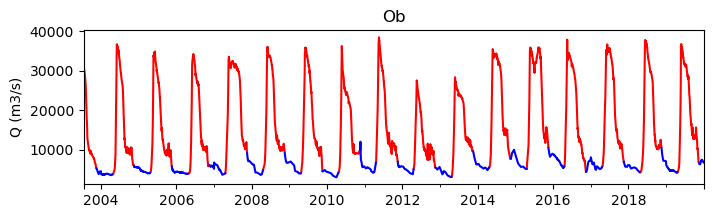

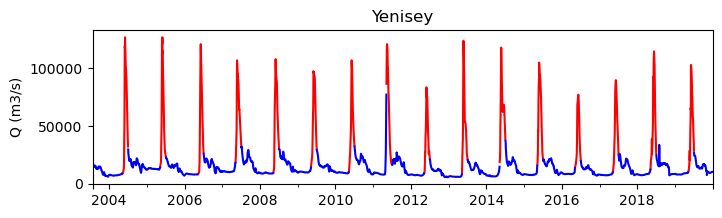

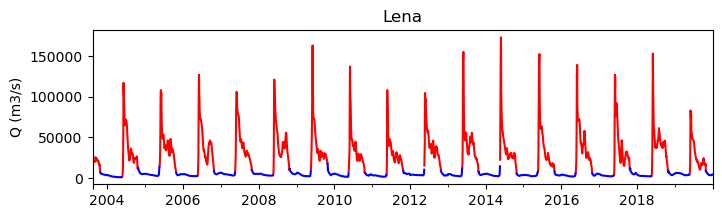

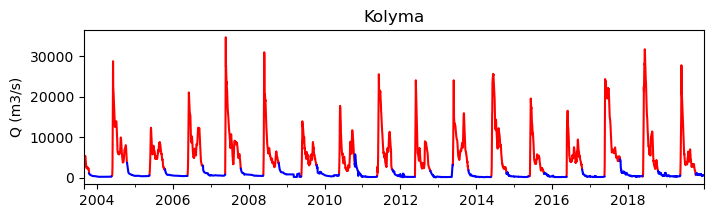

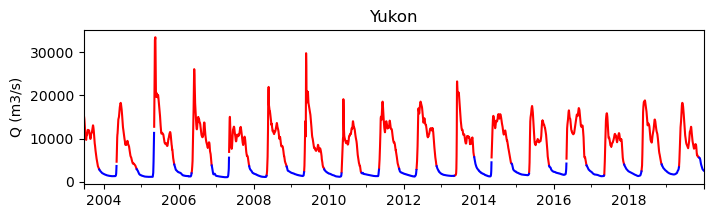

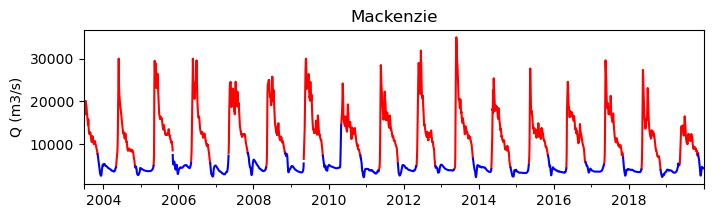

In [26]:
# Plot periods classed as summer vs winter

for river in rivers_li:
    df = chem_q_daily_dict[river][['Q', 'DOC']].copy()
    df_wint, df_summ = split_df_by_season(df, season_thresh_df, river)

    fig = plt.figure(figsize=(8, 2))
    ax = plt.subplot(111)
    df_summ['Q'].plot(ax=ax, color='red')
    df_wint['Q'].plot(ax=ax, color='blue')
    plt.title(river)
    plt.xlabel('')
    plt.ylabel('Q (m3/s)')

N.B. the small gap between summer and winter time series in some years is because the two series are plotted independently, so there is no interpolation. But the summ & wint dfs have correct values for 2 consecutive days.

Ob, n zeros in DON = 1. Replaced with NaNs
Yukon, n zeros in DON = 2. Replaced with NaNs
Ob, n zeros in NO3 = 3. Replaced with NaNs
Yenisey, n zeros in NO3 = 2. Replaced with NaNs
Lena, n zeros in NO3 = 2. Replaced with NaNs
Kolyma, n zeros in NO3 = 1. Replaced with NaNs
Ob, n zeros in NH4 = 5. Replaced with NaNs
Yenisey, n zeros in NH4 = 15. Replaced with NaNs
Lena, n zeros in NH4 = 8. Replaced with NaNs
Kolyma, n zeros in NH4 = 7. Replaced with NaNs
Yukon, n zeros in NH4 = 2. Replaced with NaNs
Mackenzie, n zeros in NH4 = 13. Replaced with NaNs
Ob, n zeros in DHP = 4. Replaced with NaNs
Yenisey, n zeros in DHP = 15. Replaced with NaNs
Lena, n zeros in DHP = 13. Replaced with NaNs
Kolyma, n zeros in DHP = 11. Replaced with NaNs
Yukon, n zeros in DHP = 9. Replaced with NaNs
Mackenzie, n zeros in DHP = 1. Replaced with NaNs


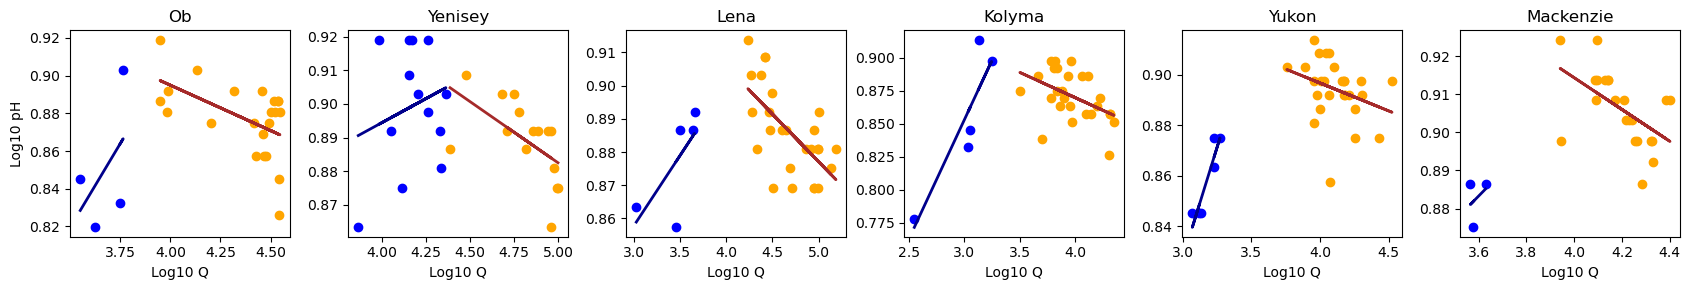

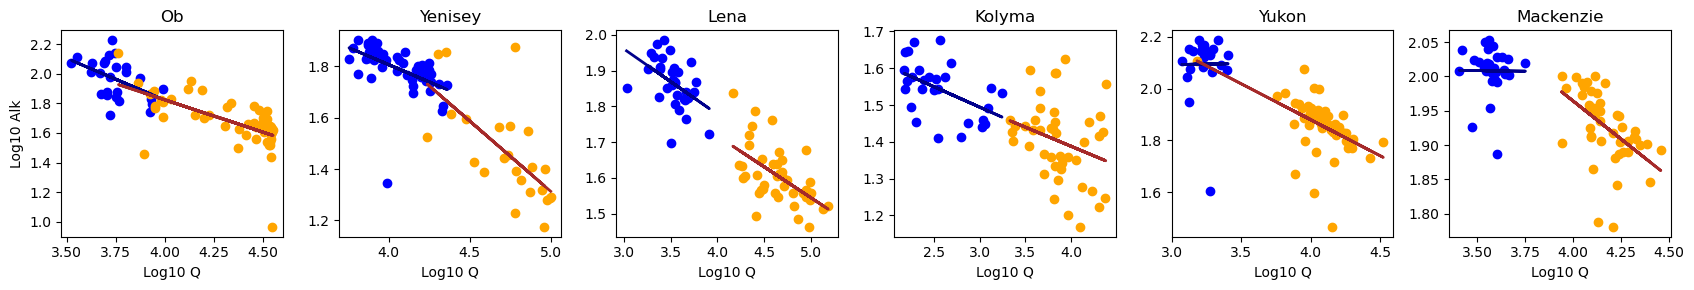

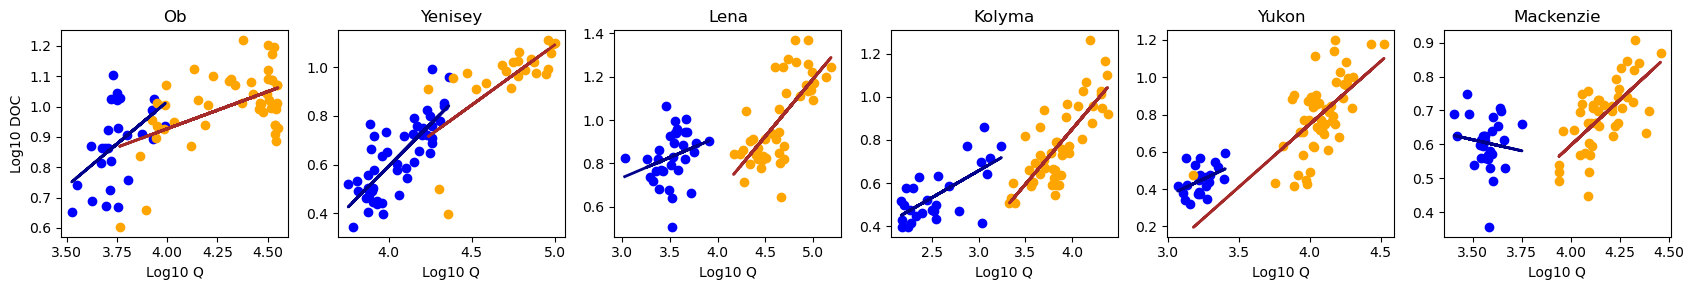

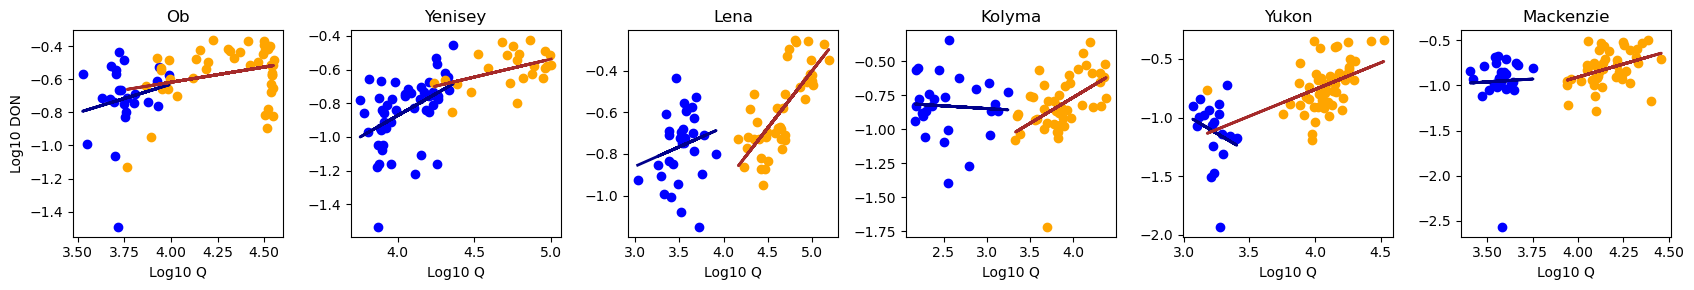

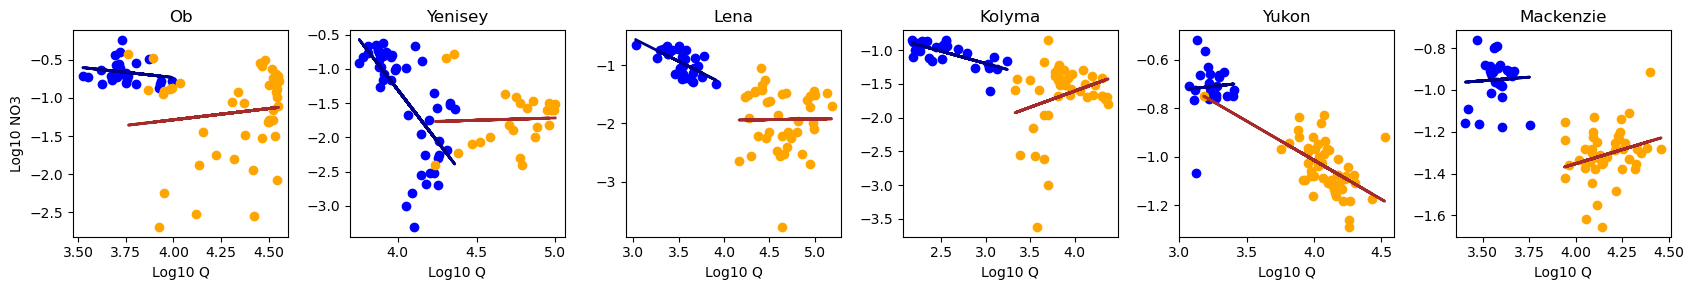

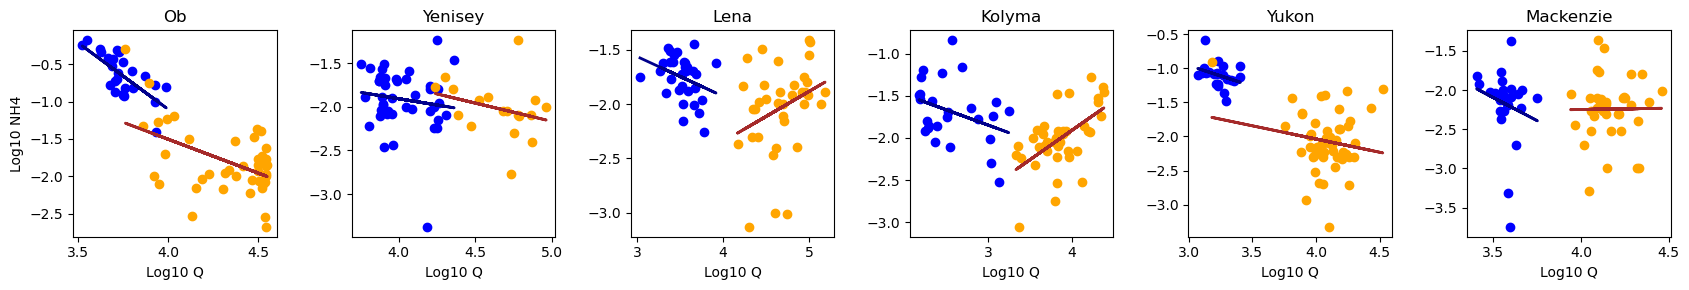

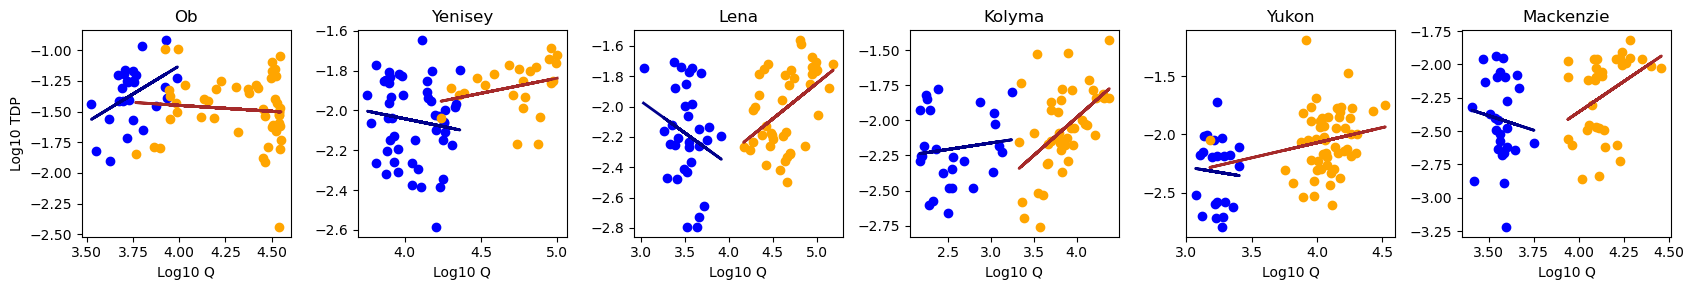

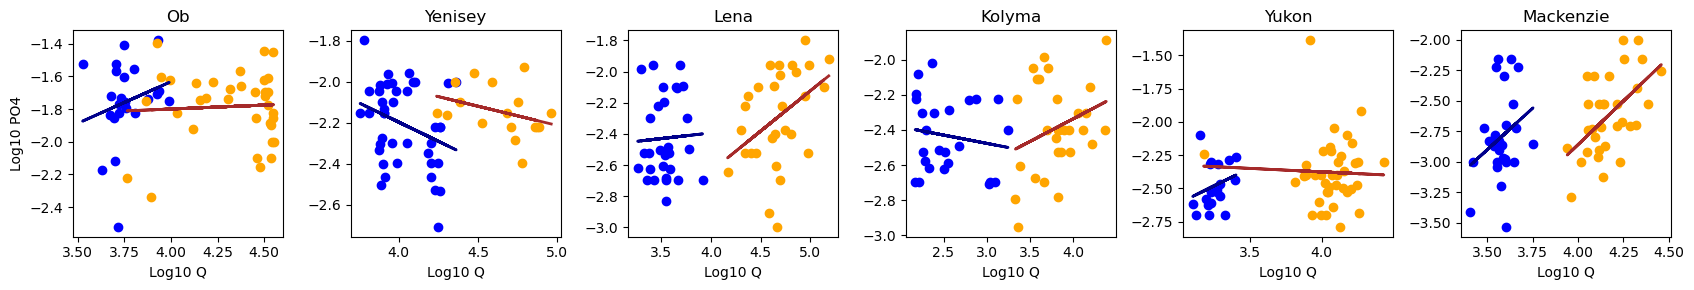

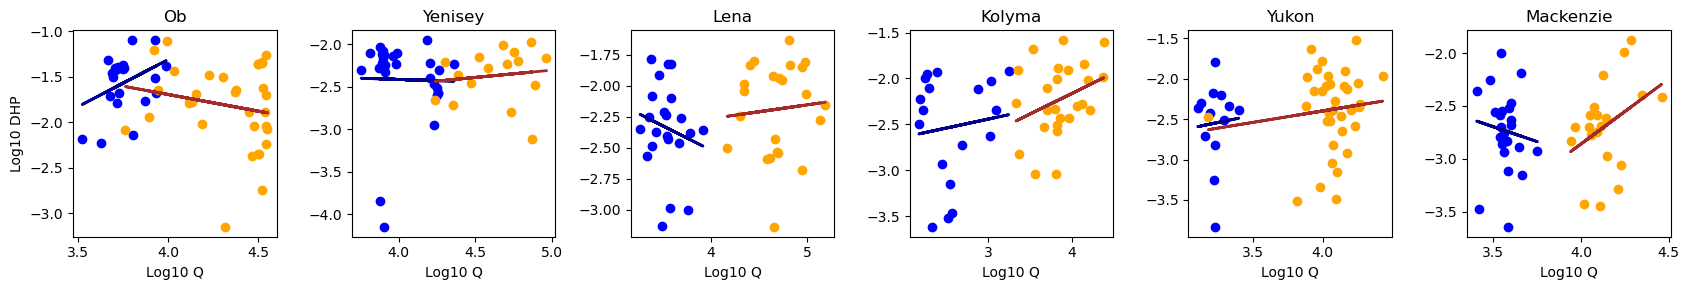

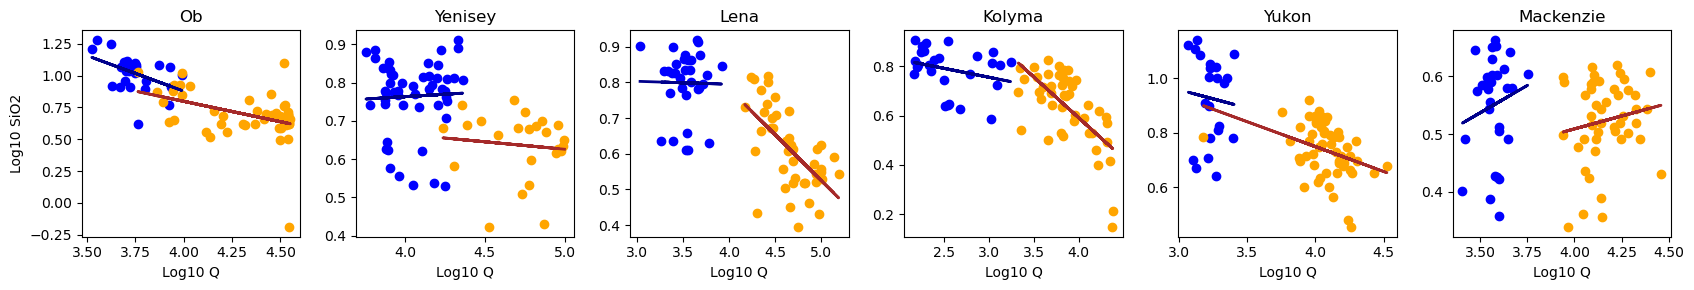

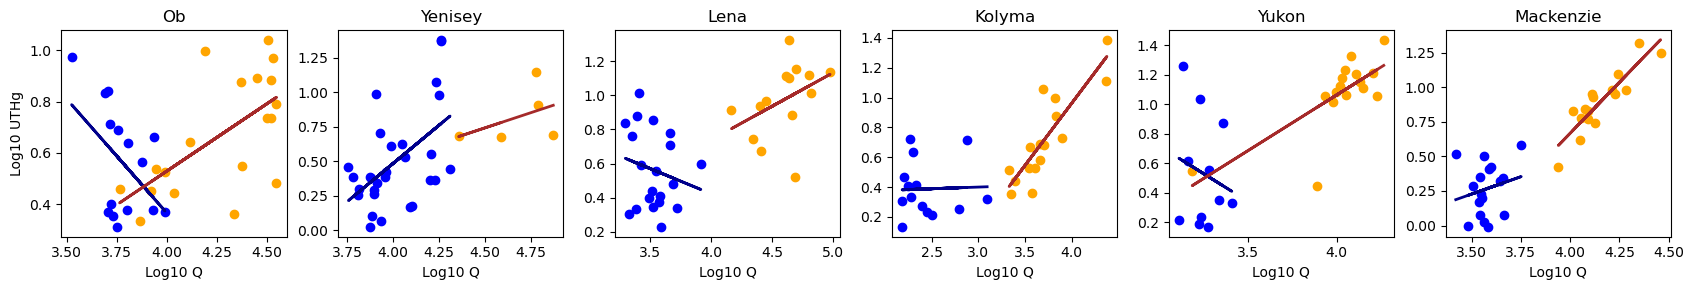

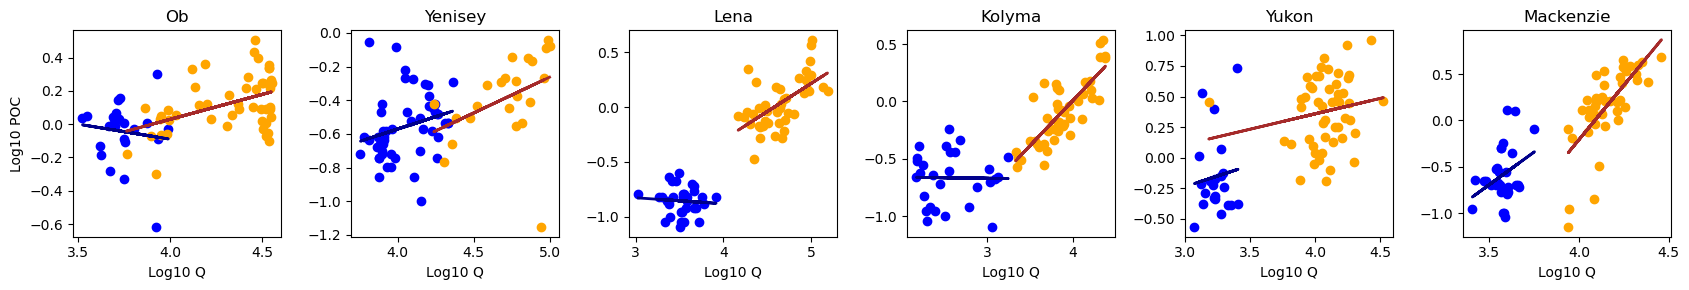

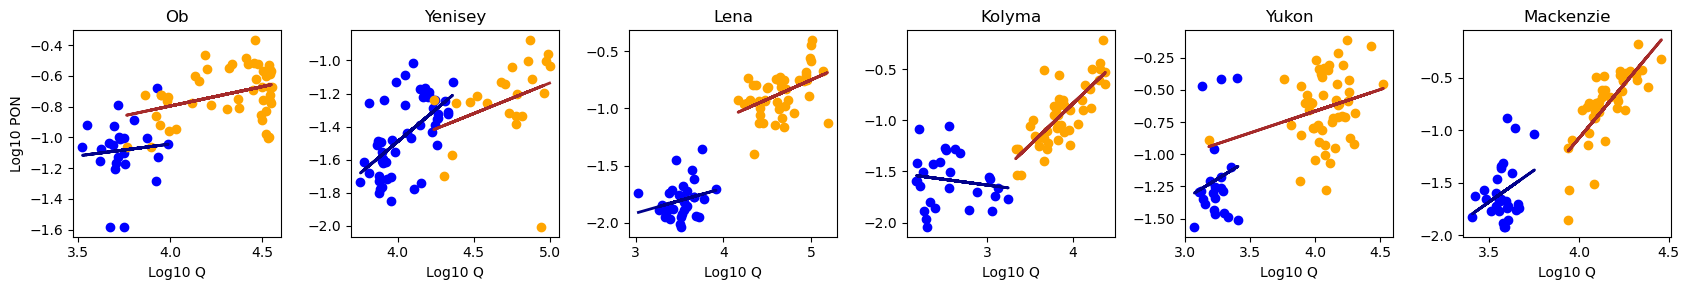

In [27]:
stats_li = []
alphas_li = []

for chem_var in chem_vars_cq:
    reg_dict_log[(chem_var, 'seasonal')], alphas, stats = q_c_linear_regression(
        chem_q_daily_dict, chem_var, out_folder_qc, log_chem=True, log_q=True,
        season_split=True
    )

    stats_li.append(stats)
    alphas_li.append(alphas)

# Add results from previous regression using annual data
# (i.e. without seasonal split)
stats_li.append(stats_df)
alphas_li.append(alpha_df)

stats_df = pd.concat(stats_li, axis=0)
alpha_df = pd.concat(alphas_li, axis=0)

In [20]:
out_folder_stats = os.path.join(out_folder_qc, "logc-logq_stats.csv")
stats_df.round(3).to_csv(out_folder_stats)
stats_df.round(3)

chem_var      river  season   r_sq   rmse  bias
0        pH         Ob  winter  0.247  0.028  -0.0
1        pH         Ob  summer  0.277  0.017   0.0
2        pH    Yenisey  winter  0.052  0.017  -0.0
3        pH    Yenisey  summer  0.321  0.010  -0.0
4        pH       Lena  winter  0.477  0.010   0.0
..      ...        ...     ...    ...    ...   ...
1       PON    Yenisey  annual  0.324  0.205  -0.0
2       PON       Lena  annual  0.840  0.198  -0.0
3       PON     Kolyma  annual  0.626  0.257   0.0
4       PON      Yukon  annual  0.456  0.286  -0.0
5       PON  Mackenzie  annual  0.788  0.236   0.0

[234 rows x 6 columns]

# Relationships between chem vars

## Exploration

In [21]:
def chem_ratios(x_var, y_var):

    ratio_df = pd.DataFrame()
    fig, axs = plt.subplots(nrows=1, ncols=len(rivers_li),
                            sharex=False, sharey=False, figsize=(17, 3))
    axs = axs.flatten()

    for i, river in enumerate(rivers_li):
        df = chem_dict[river]

        mean_ratio = df['%s_%s' % (x_var, y_var)].dropna().mean()
        ratio_df.loc[river, 'Mean_%s_%s' % (x_var, y_var)] = mean_ratio

        # Plot scatter of x_var vs y_var
        axs[i].scatter(df[x_var], df[y_var], color="black")
        axs[i].set_xlabel(x_var)
        if i == 0:
            axs[i].set_ylabel(y_var)
        axs[i].set_title(river)

    mean_ratio = ratio_df.mean().values[0]

    plt.tight_layout()

    # Check for relationship between ratio and flow
    model_dict, r2s, alphas = q_c_linear_regression(chem_q_daily_dict, '%s_%s' % (x_var, y_var),
                                                    out_folder_qc,
                                                    log_chem=True,
                                                    log_q=True)

    print("Mean %s:%s ratio in ArcticGRO rivs: %s" % (x_var, y_var, mean_ratio))

    return(ratio_df)

Mean DOC:DON ratio in ArcticGRO rivs: 39.6318923841362


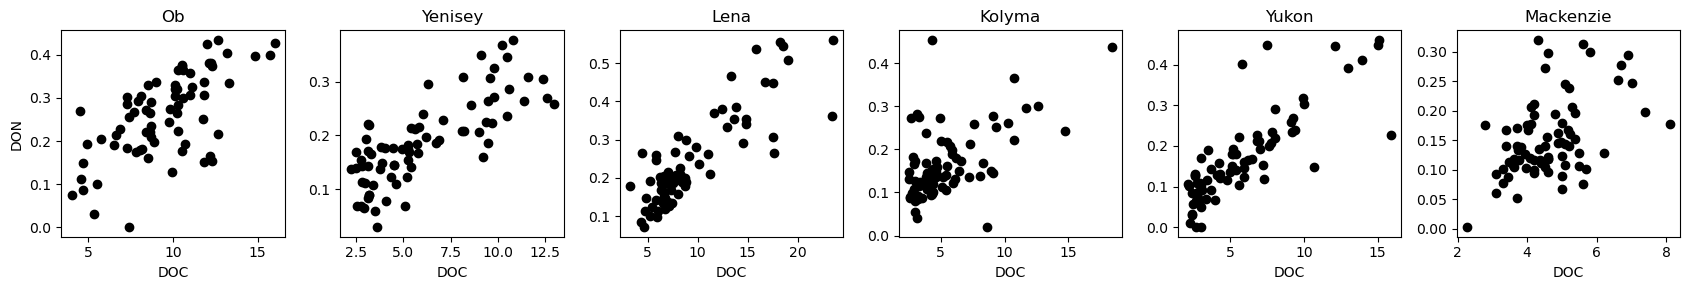

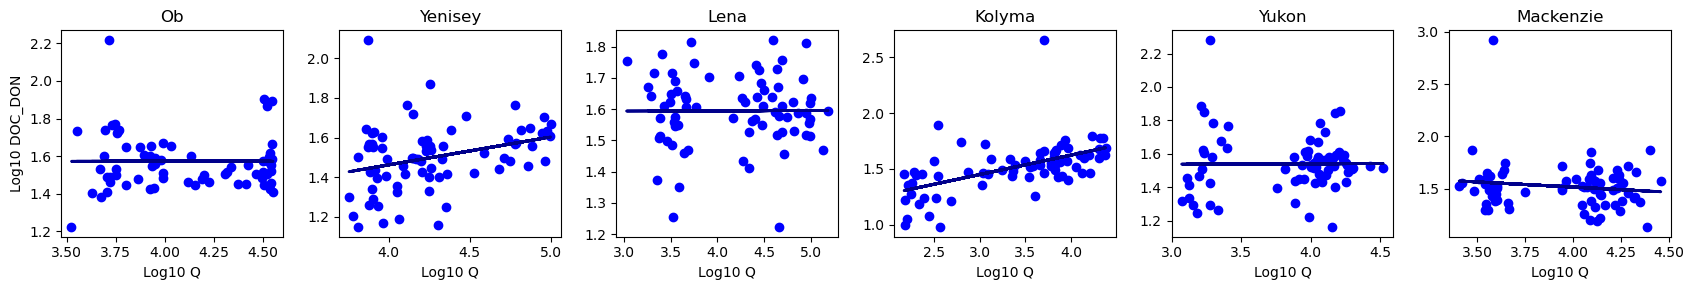

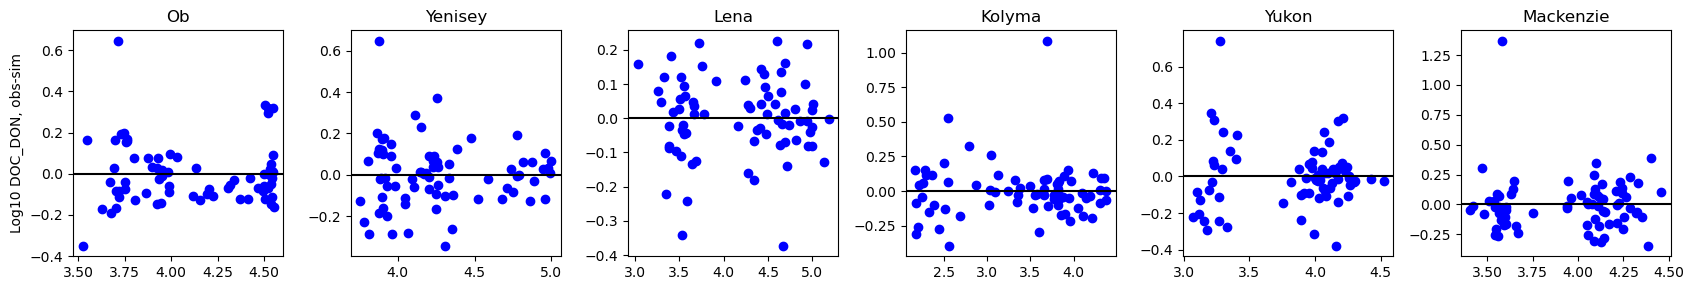

In [22]:
doc_don_df = chem_ratios('DOC', 'DON')

Ob, n zeros in DHP_DOC = 4. Replaced with NaNs
Yenisey, n zeros in DHP_DOC = 15. Replaced with NaNs
Lena, n zeros in DHP_DOC = 13. Replaced with NaNs
Kolyma, n zeros in DHP_DOC = 11. Replaced with NaNs
Yukon, n zeros in DHP_DOC = 9. Replaced with NaNs
Mackenzie, n zeros in DHP_DOC = 1. Replaced with NaNs
Mean DHP:DOC ratio in ArcticGRO rivs: 0.0011971032995144436


Mean_DHP_DOC
Ob             0.002931
Yenisey        0.000793
Lena           0.000635
Kolyma         0.001188
Yukon          0.001027
Mackenzie      0.000610

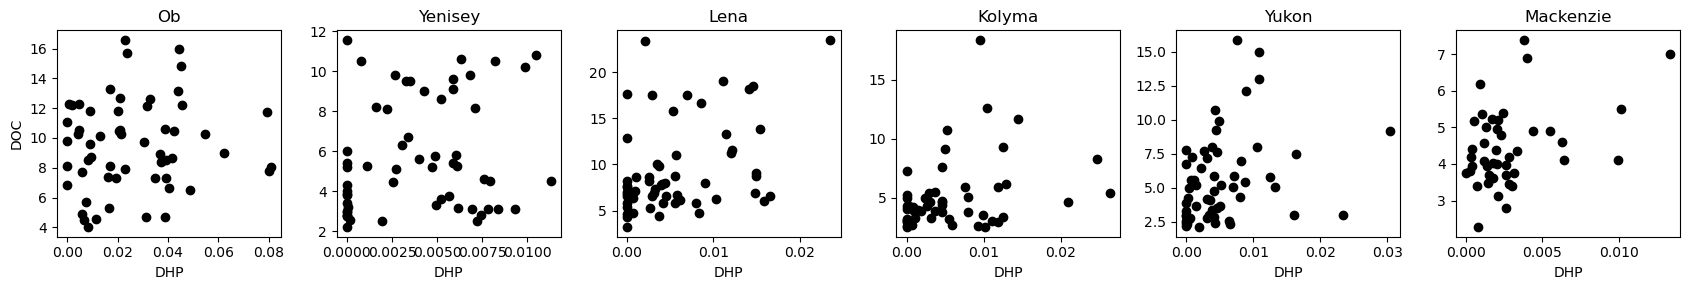

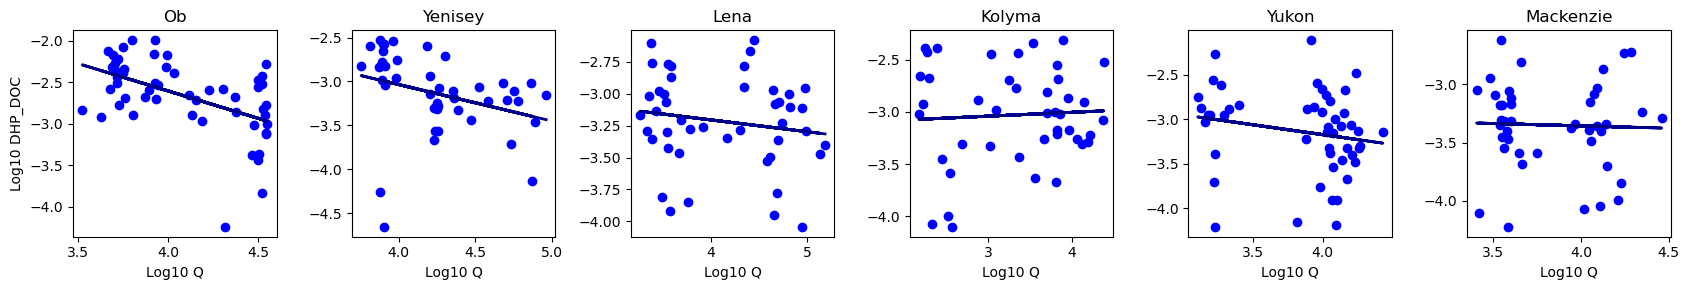

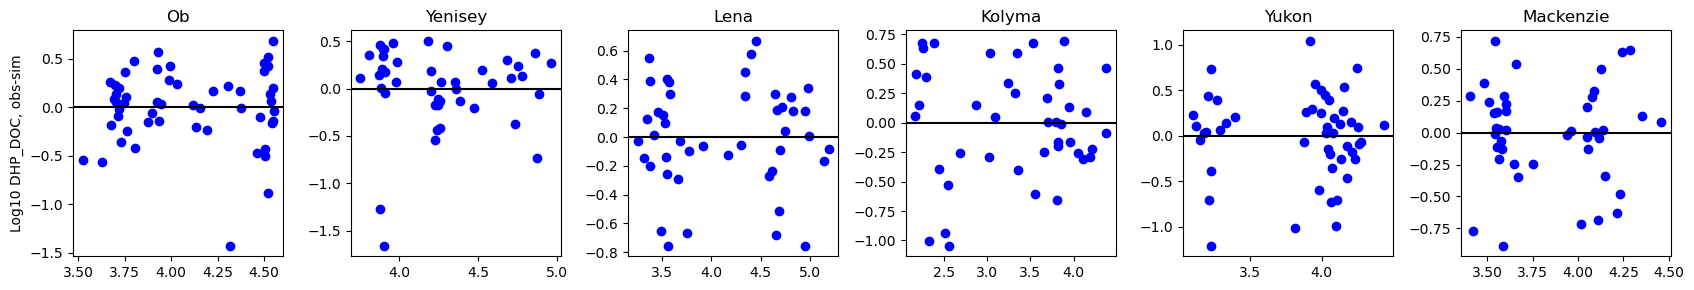

In [23]:
chem_ratios('DHP', 'DOC')

Mean TDP:DOC ratio in ArcticGRO rivs: 0.002225665914871259


Mean_TDP_DOC
Ob             0.004751
Yenisey        0.002181
Lena           0.001118
Kolyma         0.001942
Yukon          0.001947
Mackenzie      0.001415

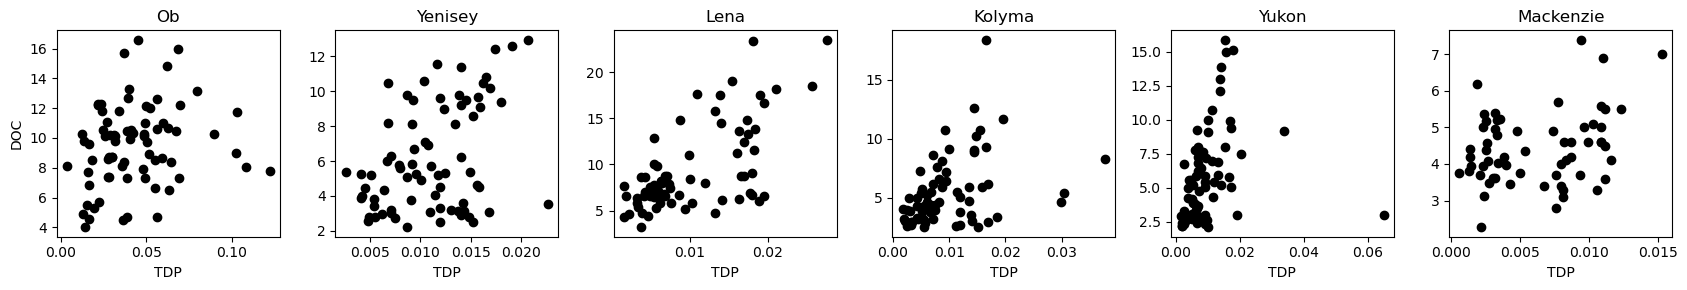

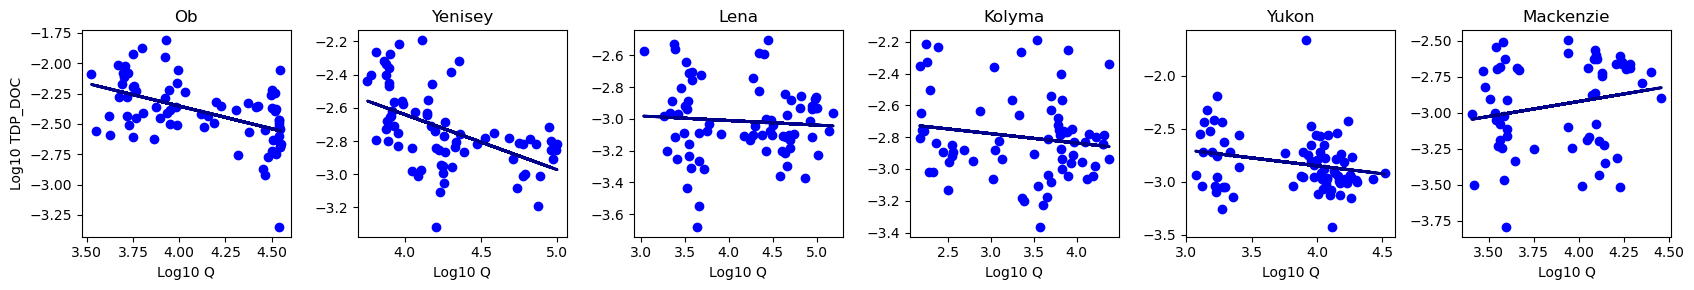

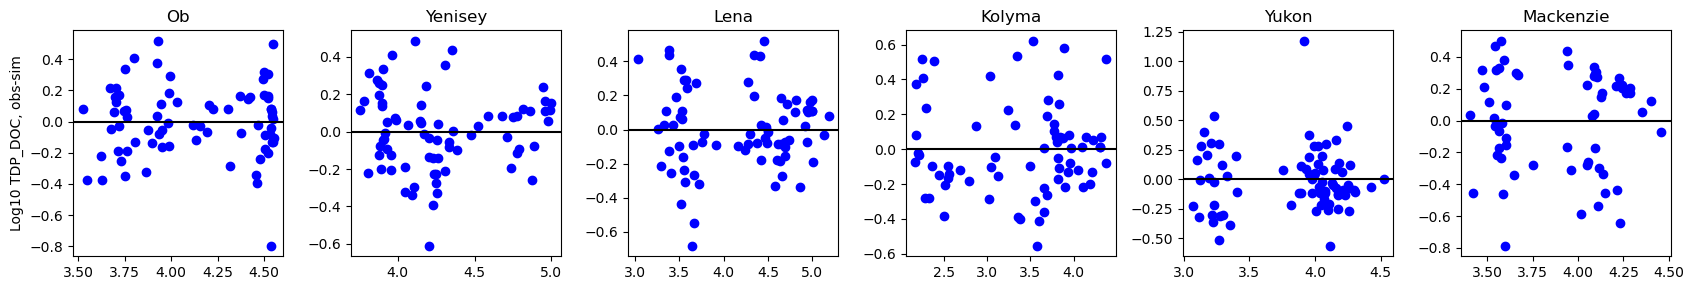

In [24]:
chem_ratios('TDP', 'DOC')

Mean UTHg:DOC ratio in ArcticGRO rivs: 1.1350831185712613


Mean_UTHg_DOC
Ob              0.552253
Yenisey         1.027093
Lena            0.959230
Kolyma          1.011782
Yukon           2.155568
Mackenzie       1.104573

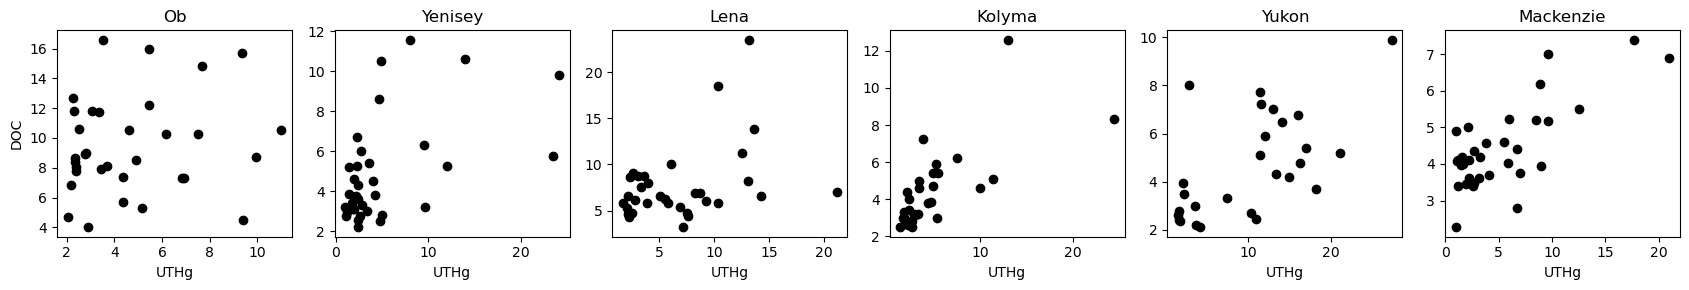

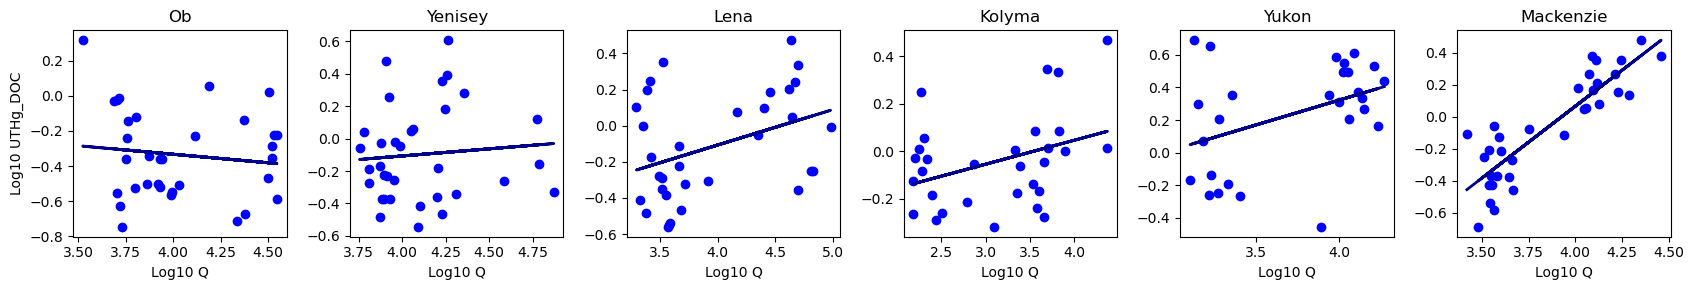

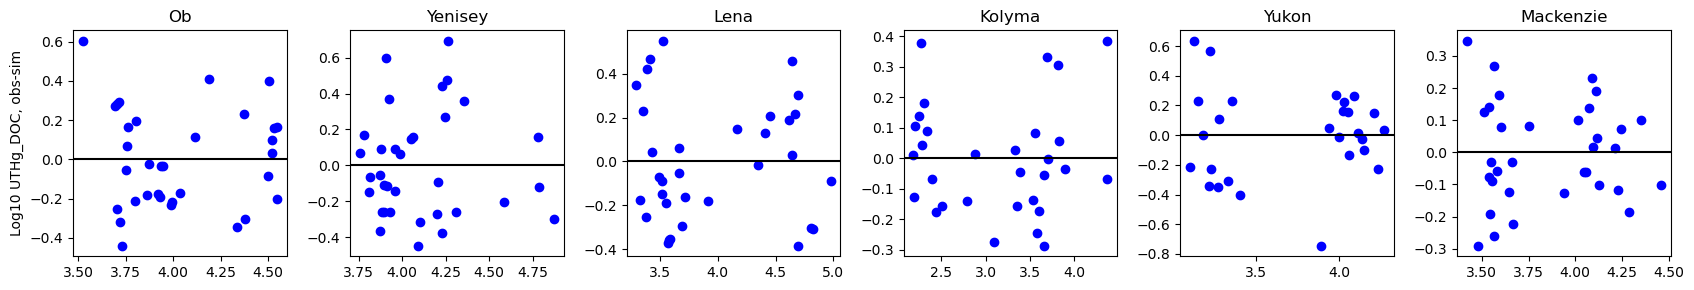

In [25]:
chem_ratios('UTHg', 'DOC')

**In summary:**

* Decide to use CQ relationships for all but DON. Use DOC for this.
* total Hg does not vary with DOC in Ob, suggesting little OM complexation. Mixed in the other rivers. 
* THg/DOC vs Q plots don't show anything much apart from in Mackenzie, where there is a strong positive relationship

# Interpolation

## Using daily data

Have a quick play with interpolating instead of using regressions to get daily chem data (like I did at Langtjern).

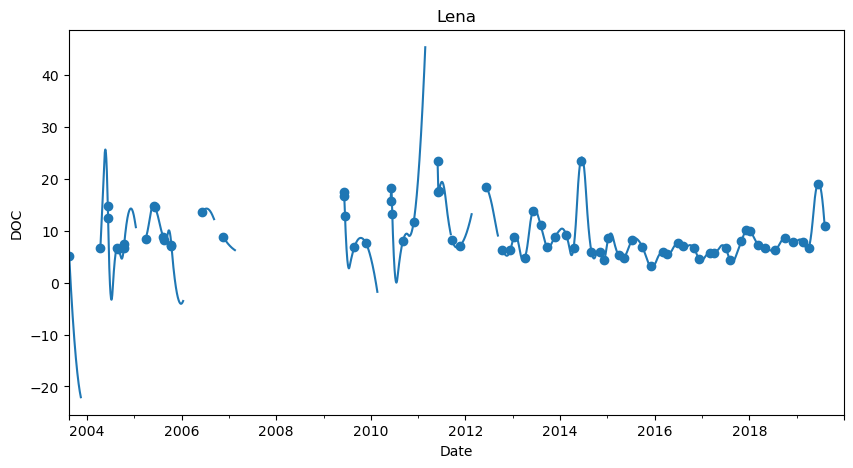

In [26]:
river = 'Lena'
chem = 'DOC'

df = chem_q_daily_dict[river][chem].to_frame()
df['%s_interp' % chem] = df['%s' % chem]
df['%s_interp' % chem] = df['%s' % chem].interpolate(method='polynomial',
                                                     order=2,
                                                     limit=90)

ax = df['%s_interp' % chem].plot(figsize=(10, 5))
plt.scatter(df.index, df['%s' % chem])
# predicted_chem_daily_dict[chem][river].loc['2003-01-01':].plot(ax=ax, linestyle=None, grid=True)
plt.ylabel('%s' % chem)
plt.title(river);

Decide not to pursue for now. Linear misses peaks, whilst polynomial fits some likely peaks better than linear, but does dangerous things.

## Using monthly mean data

In [27]:
chem_q_daily_dict[river][chem]

Date
2003-08-12    NaN
2003-08-13    NaN
2003-08-14    NaN
2003-08-15    NaN
2003-08-16    5.2
             ... 
2019-12-27    NaN
2019-12-28    NaN
2019-12-29    NaN
2019-12-30    NaN
2019-12-31    NaN
Freq: D, Name: DOC, Length: 5986, dtype: float64

DOC  DOC_interp
Date                        
2009-04-30   NaN         NaN
2009-05-31   NaN         NaN
2009-06-30  15.7   15.700000
2009-07-31   NaN   10.147366
2009-08-31   6.8    6.800000

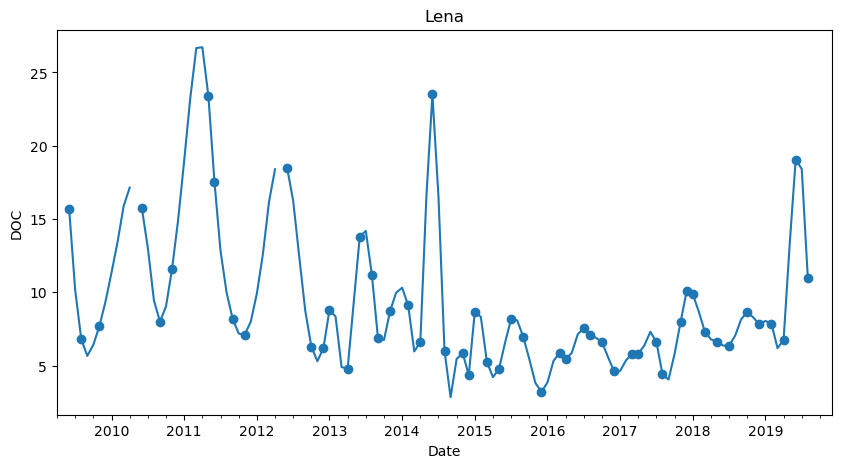

In [28]:
river = 'Lena'
chem = 'DOC'

daily_df = chem_q_daily_dict[river][chem].to_frame()
monthly_df = daily_df.resample('M').agg(np.mean)
monthly_df = monthly_df.loc['2009-04-01':, :]
monthly_df['%s_interp' % chem] = monthly_df['%s' % chem]
monthly_df['%s_interp' % chem] = monthly_df['%s' % chem].interpolate(method='polynomial',
                                                                     order=2,
                                                                     limit=5)

ax = monthly_df['%s_interp' % chem].plot(figsize=(10, 5))
plt.scatter(monthly_df.index, monthly_df['%s' % chem])
# predicted_chem_daily_dict[chem][river].loc['2003-01-01':].plot(ax=ax, linestyle=None, grid=True)
plt.ylabel('%s' % chem)
plt.title(river);

monthly_df.head()

# for chem in predicted_chem_daily_dict.keys():
#     daily_df = predicted_chem_daily_dict[chem]
#     monthly_df = daily_df.resample('M').agg(np.mean)

This looks ok for the period 2009-2020, certainly fits the data better than the CQ relationship (of course, as the line goes right through the points). Although I'm actually a bit skeptical about the DOC data for the period 2009-2012 (incl.), it is so much higher than later in the record. **Is this a real difference in DOC? Or a difference in lab methods?**

# Predict chem for the period 1980-2019

In [29]:
def plot_predicted_obs_chem(df, chem, folder_for_graphs):
    """ Plot timeseries of predicted and observed for one chem variable,
        with one subplot per river. Save plots to file.
    """
    fig, axs = plt.subplots(len(rivers_li), 1, figsize=(12, 15))
    axs = axs.flatten()

    for i, river in enumerate(df.columns):
        pred = df[river]
        pred.loc['2003-01-01': '2019-12-31'].plot(ax=axs[i], label='Predicted')
        obs = chem_dict[river][chem]
        obs.loc['2003-01-01': '2019-12-31'].plot(marker='o',
                                                 color='k',
                                                 markersize=4,
                                                 linestyle='none',
                                                 grid=True,
                                                 ax=axs[i],
                                                 label='Observed')
        axs[i].set_ylabel(chem)
        axs[i].set_xlabel("")
        axs[i].set_title(river)
        if i == len(rivers_li)-1:
            axs[i].legend(loc='upper right')

    plt.tight_layout()
    fpath = os.path.join(folder_for_graphs,
                         'predicted-vs-observed_%s.png' % chem)
    plt.savefig(fpath, dpi=300)

## Read in filled Q data to use for prediction

Q data used for deriving relationships was raw data, to not introduce noise from errors in interpolating/filling the Q series. However, for prediction I will use the filled/patched and therefore complete daily Q time series derived in previous notebooks.

In [30]:
complete_q_fpath = r'~/shared/pan_arctic_data/discharge/ArcticGRO_big6_daily_area-scaled_radr-patched_wide.csv'
full_q_df = pd.read_csv(complete_q_fpath, index_col=0, parse_dates=True)
full_q_df.head()

Kolyma     Lena  Mackenzie      Ob  Yenisey    Yukon
date                                                            
1980-01-01  171.35  4492.53    2525.22  7360.0  7835.22  1993.49
1980-01-02  173.84  4492.53    2589.97  7350.0  7782.56  1993.49
1980-01-03  175.08  4451.97    2676.30  7350.0  7687.78  1993.49
1980-01-04  176.32  4451.97    2730.26  7320.0  7645.66  1993.49
1980-01-05  177.56  4451.97    2687.10  7290.0  7603.53  1993.49

## All but DON and PO4: Predict using CQ relationships

**To do still:**
* Some variables should use seasonal regressions, others not. Set that up here.
* Using 2 different regressions for different time periods leads to a step change in predictions when you switch from one to the other. Perhaps this doesn't matter after averaging to monthly frequency, but one idea is to drop predictions over a window (e.g. 2 weeks) either side of the cutoff date, and then interpolate between these dates to create a smoother daily signal. Will try that.

In [31]:
chem_vars_cq = [
    "Alk",
    "DOC",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
]


def predict(model, alpha, river):
    pred = 10 ** (model.intercept_ + model.coef_ * log10q)
    pred = alpha * pred
    pred.name = river
    return pred


predicted_chem_daily_dict = {}  # key: chem, returns df with one col per river

# for chem in chem_vars_cq:
for chem in ['DOC']:  # for testing

    pred_li = []
    pred_li_season = []

    for i, river in enumerate(rivers_li):

        # Q data to make predictions with
        q = full_q_df[river].squeeze()
        log10q = np.log10(q)

        # Get regression result for annually-aggregated data
        model = reg_dict_log[(chem, 'annual')][(river, 'annual')]
        alpha = alpha_df.query("river == @river and chem_var == @chem and season == 'annual'")['alpha'].values[0]
        # alpha = 1.0

        # Predict and back-transform from log scale with bias correcn
        pred = predict(model, alpha, river)
        pred_li.append(pred)

        # Get regression result & predict for seasonally-aggregated data. Just go verbose for now!
        model_summer = reg_dict_log[(chem, 'seasonal')][(river, 'summer')]
        model_winter = reg_dict_log[(chem, 'seasonal')][(river, 'winter')]
        alpha_summer = alpha_df.query("river == @river and chem_var == @chem and season == 'summer'")['alpha'].values[0]
        alpha_winter = alpha_df.query("river == @river and chem_var == @chem and season == 'winter'")['alpha'].values[0]

        pred_summer = predict(model_summer, alpha_summer, river)
        pred_winter = predict(model_winter, alpha_winter, river)
        pred_season = pred_winter.copy()
        pred_season[(season_thresh_df.loc[river]['start'] < pred_season.index.day_of_year) &
                    (pred_season.index.day_of_year < season_thresh_df.loc[river]['end'])] = np.NaN
        pred_season = pred_season.combine_first(pred_summer)
        pred_li_season.append(pred_season)

    # Make dataframe for this variable and save in dict and to file
    pred_df_annual = pd.concat(pred_li, axis=1)
    pred_df_seasonal = pd.concat(pred_li_season, axis=1)
    predicted_chem_daily_dict[(chem, 'annual')] = pred_df_annual
    predicted_chem_daily_dict[(chem, 'seasonal')] = pred_df_seasonal

    pred_annual_fpath = os.path.join(out_folder_predictions,
                                     'daily', 'annual-regression_%s.csv' % chem)
    pred_df_annual.to_csv(pred_annual_fpath)

    pred_seasonal_fpath = os.path.join(out_folder_predictions,
                                       'daily', 'seasonal-regression_%s.csv' % chem)
    pred_df_seasonal.to_csv(pred_seasonal_fpath)

# Display example output
predicted_chem_daily_dict[('DOC', 'annual')]

Ob   Yenisey      Lena    Kolyma     Yukon  Mackenzie
date                                                                   
1980-01-01  8.135764  3.577785  7.145922  2.893934  3.006629   3.734481
1980-01-02  8.133054  3.565362  7.145922  2.903132  3.006629   3.750429
1980-01-03  8.133054  3.542898  7.133216  2.907674  3.006629   3.771183
1980-01-04  8.124905  3.532873  7.133216  2.912191  3.006629   3.783874
1980-01-05  8.116732  3.522818  7.133216  2.916683  3.006629   3.773740
...              ...       ...       ...       ...       ...        ...
2019-12-27  8.016610  4.231359  7.054957  4.005605  3.493619   4.152114
2019-12-28  8.008090  4.231359  7.054957  4.040025  3.475722   4.152750
2019-12-29  7.999543  4.252499  7.091264  4.044250  3.449544   4.153226
2019-12-30  7.973731  4.252499  7.097784  4.032938  3.427842   4.152908
2019-12-31  7.965069  4.252499  7.104282  4.035774  3.419587   4.150681

[14610 rows x 6 columns]

In [37]:
# pred_season.loc[season_thresh_df.loc[river]['start']-5: season_thresh_df.loc[river]['start']+5]
season_thresh_df.loc[river]['start']-5

120

/tmp/ipykernel_252/3372239355.py:9: FutureWarning: Slicing a positional slice with .loc is not supported, and will raise TypeError in a future version.  Use .loc with labels or .iloc with positions instead.
  pred_season.loc[season_thresh_df.loc[river]['start']-5: season_thresh_df.loc[river]['start']+5] = np.NaN


<AxesSubplot:xlabel='date'>

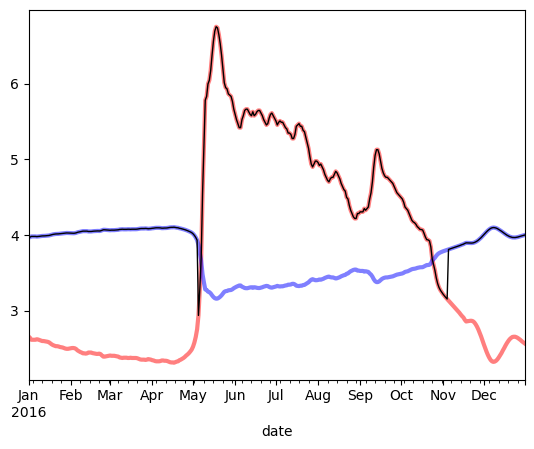

In [34]:
pred_summer = predict(model_summer, alpha_summer, river)
pred_winter = predict(model_winter, alpha_winter, river)
pred_season = pred_winter.copy()

pred_season[(season_thresh_df.loc[river]['start'] < pred_season.index.day_of_year) &
            (pred_season.index.day_of_year < season_thresh_df.loc[river]['end'])] = np.NaN
pred_season = pred_season.combine_first(pred_summer)

pred_season.loc[season_thresh_df.loc[river]['start']-5: season_thresh_df.loc[river]['start']+5] = np.NaN 

year='2016'
ax = pred_summer.loc[year].plot(color='r', lw=3, alpha=0.5)
pred_winter.loc[year].plot(color='b', lw=3, alpha=0.5)
pred_season.loc[year].plot(color='k', lw=1)
# pred.loc['2015'].plot(color='y', lw=3, alpha=0.5)

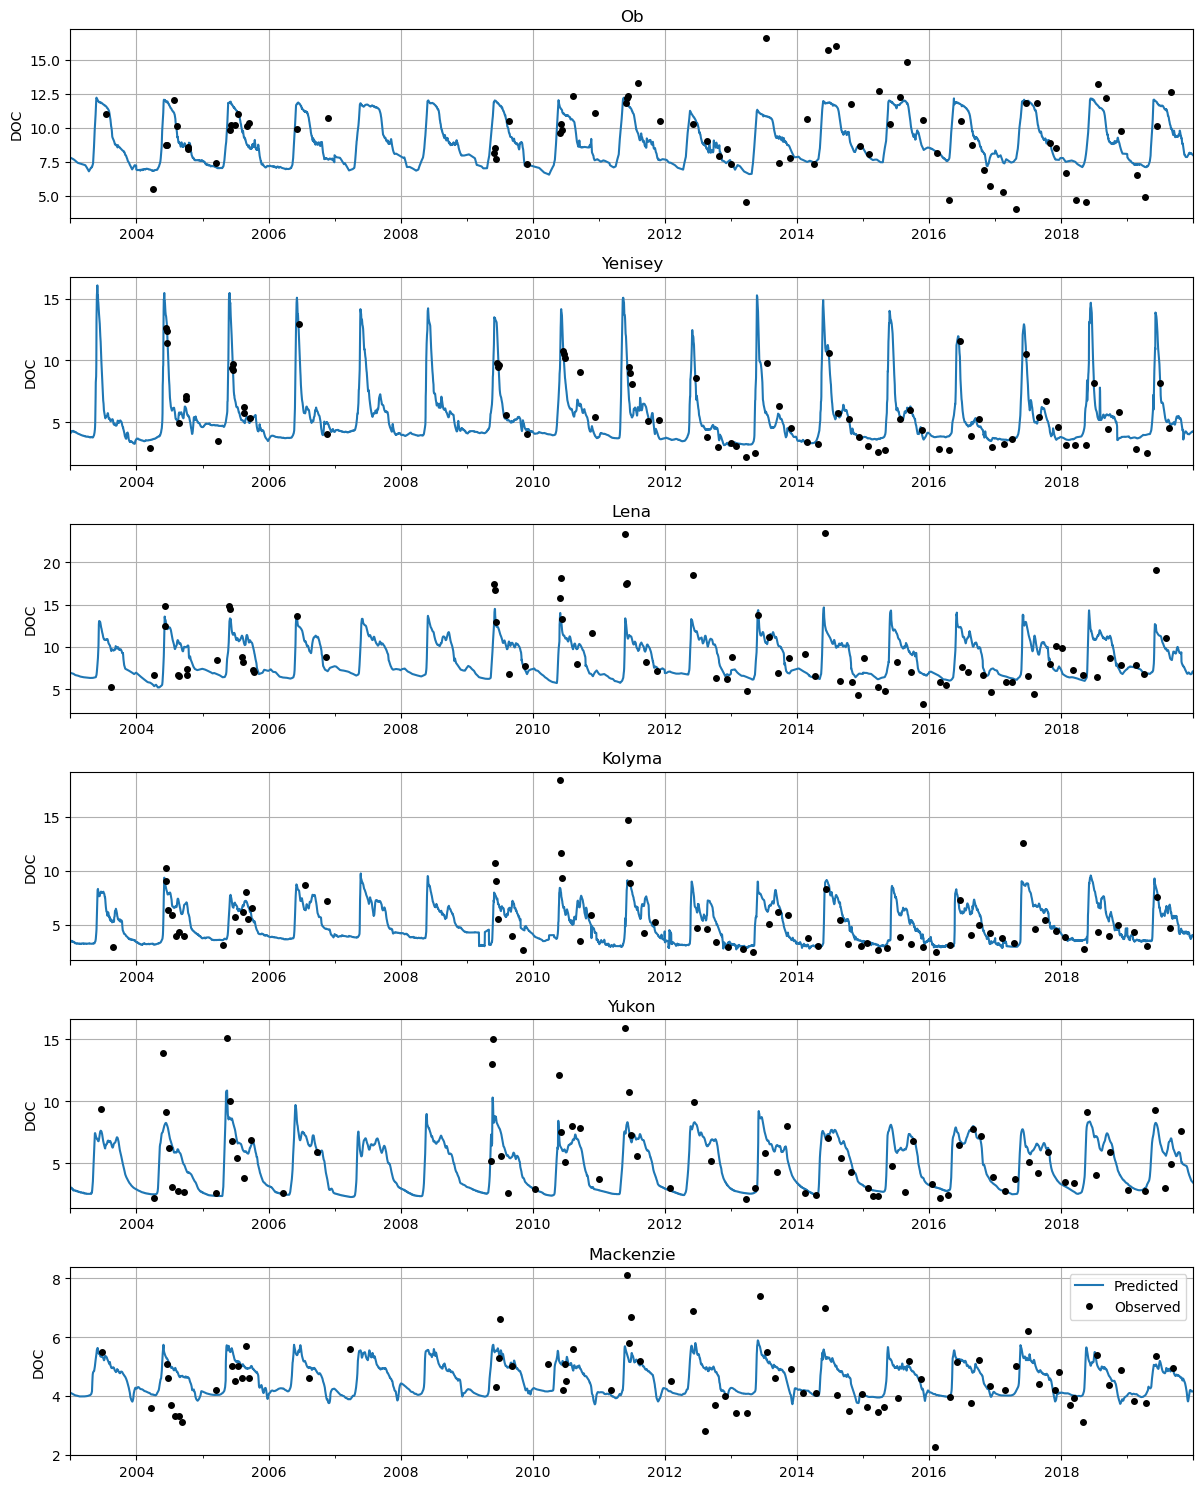

In [54]:
# Plot results using annual regression

# for chem in chem_vars_cq:
for chem in ['DOC']:  # for testing
    df = predicted_chem_daily_dict[(chem, 'annual')]
    plot_predicted_obs_chem(df, chem, out_folder_predictions_timeseries_daily)

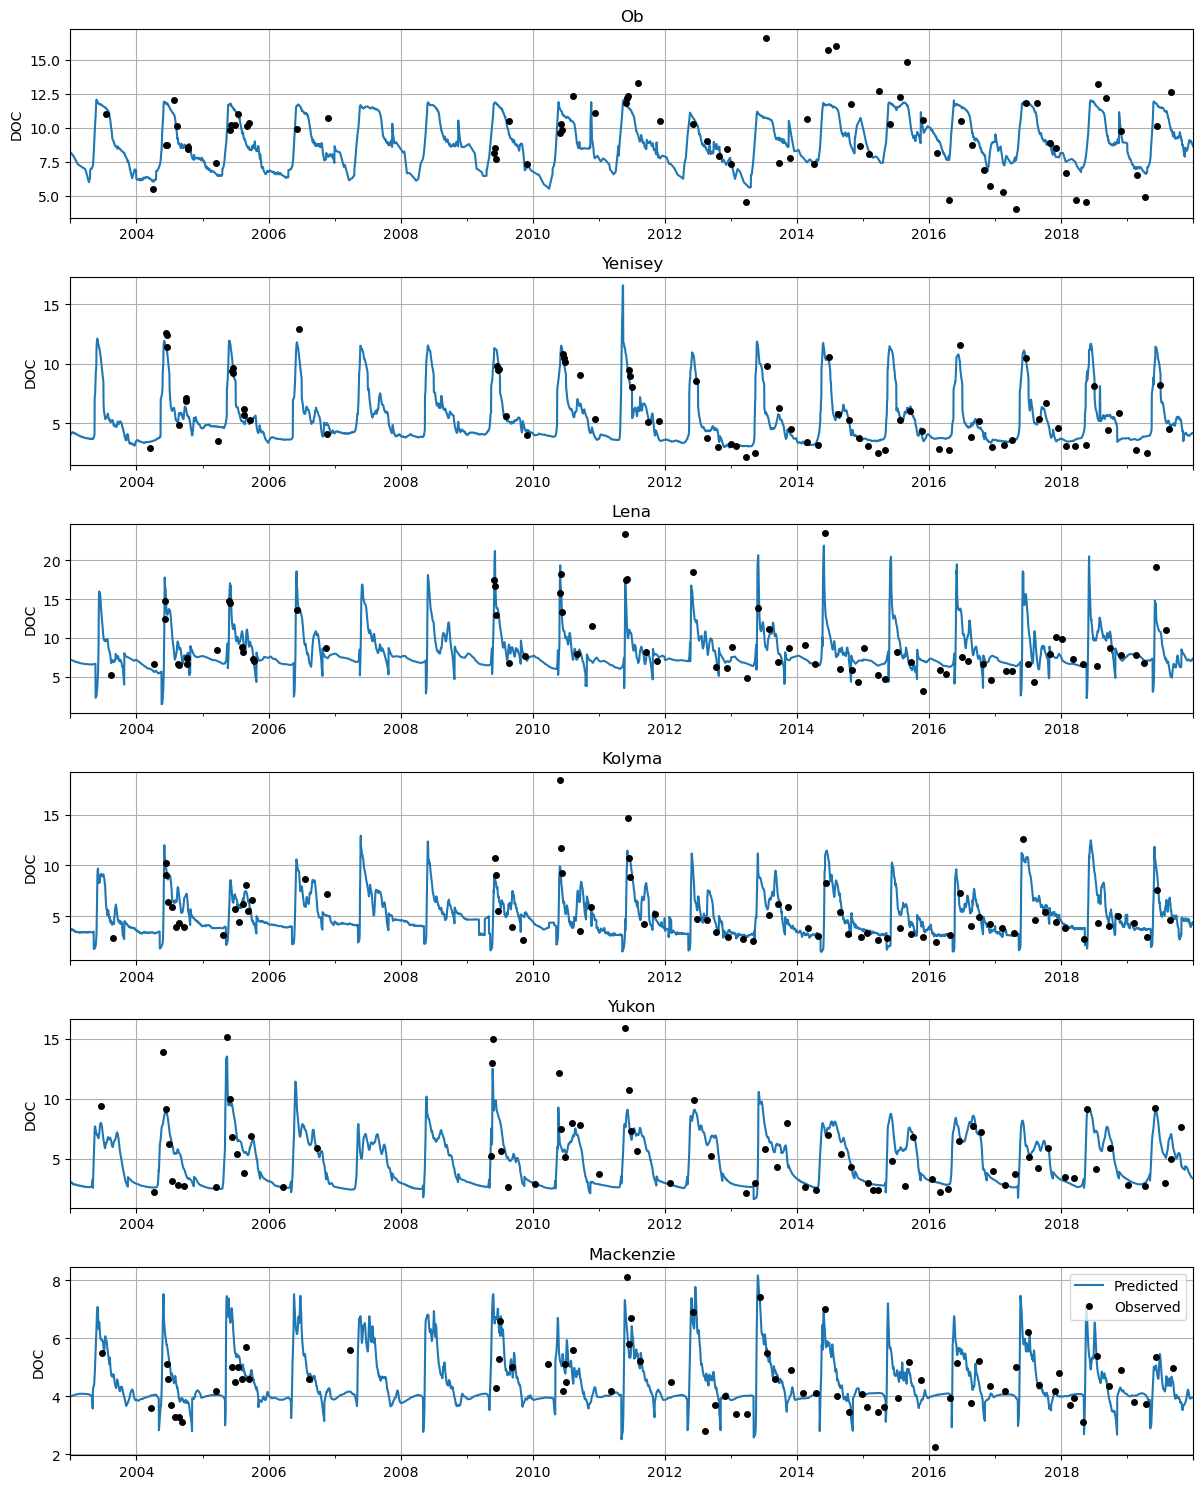

In [55]:
# for chem in chem_vars_cq:
for chem in ['DOC']:  # for testing
    df = predicted_chem_daily_dict[(chem, 'seasonal')]
    plot_predicted_obs_chem(df, chem, out_folder_predictions_timeseries_daily)

In [26]:
chem_vars_cq = [
    "Alk",
    "DOC",
    "NO3",
    "NH4",
    "TDP",
    "PO4",
    "SiO2",
    "UTHg",
    "POC",
    "PON",
]

predicted_chem_daily_dict = {}  # key: chem, returns df with one col per river

for chem in chem_vars_cq:
# for chem in ['Alk']:  # for testing

    pred_li = []

    for i, river in enumerate(rivers_li):

        # Get regression result
        model = reg_dict_log[chem][river]
        alpha = alpha_df.loc[river, chem]
        # alpha = 1.0

        # Q data to make predictions with
        q = full_q_df[river].squeeze()
        log10q = np.log10(q)

        # Predict and back-transform from log scale with bias correcn
        pred = 10 ** (model.intercept_ + model.coef_ * log10q)
        pred = alpha * pred

        # Add to results
        pred.name = river
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict and to file
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_daily_dict[chem] = pred_df
    pred_fpath = os.path.join(out_folder_predictions,
                              'daily', '%s.csv' % chem)
    pred_df.to_csv(pred_fpath)

# Display example output
# predicted_chem_daily_dict['Alk']

## Predict DON from DOC

In [28]:
doc_don_df.loc[river][0]

44.63372224366146

In [29]:
chem_vars_doc_c = ["DON"]

for var in chem_vars_doc_c:
    pred_li = []
    for river in rivers_li:
        pred = predicted_chem_daily_dict['DOC'][river] / doc_don_df.loc[river][0]
        # Add to results
        pred.name = river
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict and to file
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_daily_dict[var] = pred_df
    pred_fpath = os.path.join(out_folder_predictions,
                              'daily', '%s.csv' % var)

predicted_chem_daily_dict[var]

Ob   Yenisey      Lena    Kolyma     Yukon  Mackenzie
date                                                                   
1980-01-01  0.202275  0.105039  0.175539  0.072302  0.078830   0.083670
1980-01-02  0.202208  0.104674  0.175539  0.072532  0.078830   0.084027
1980-01-03  0.202208  0.104015  0.175227  0.072645  0.078830   0.084492
1980-01-04  0.202005  0.103721  0.175227  0.072758  0.078830   0.084776
1980-01-05  0.201802  0.103425  0.175227  0.072870  0.078830   0.084549
...              ...       ...       ...       ...       ...        ...
2019-12-27  0.199313  0.124227  0.173304  0.100076  0.091598   0.093026
2019-12-28  0.199101  0.124227  0.173304  0.100936  0.091129   0.093041
2019-12-29  0.198889  0.124848  0.174196  0.101042  0.090442   0.093051
2019-12-30  0.198247  0.124848  0.174356  0.100759  0.089873   0.093044
2019-12-31  0.198031  0.124848  0.174516  0.100830  0.089657   0.092994

[14610 rows x 6 columns]

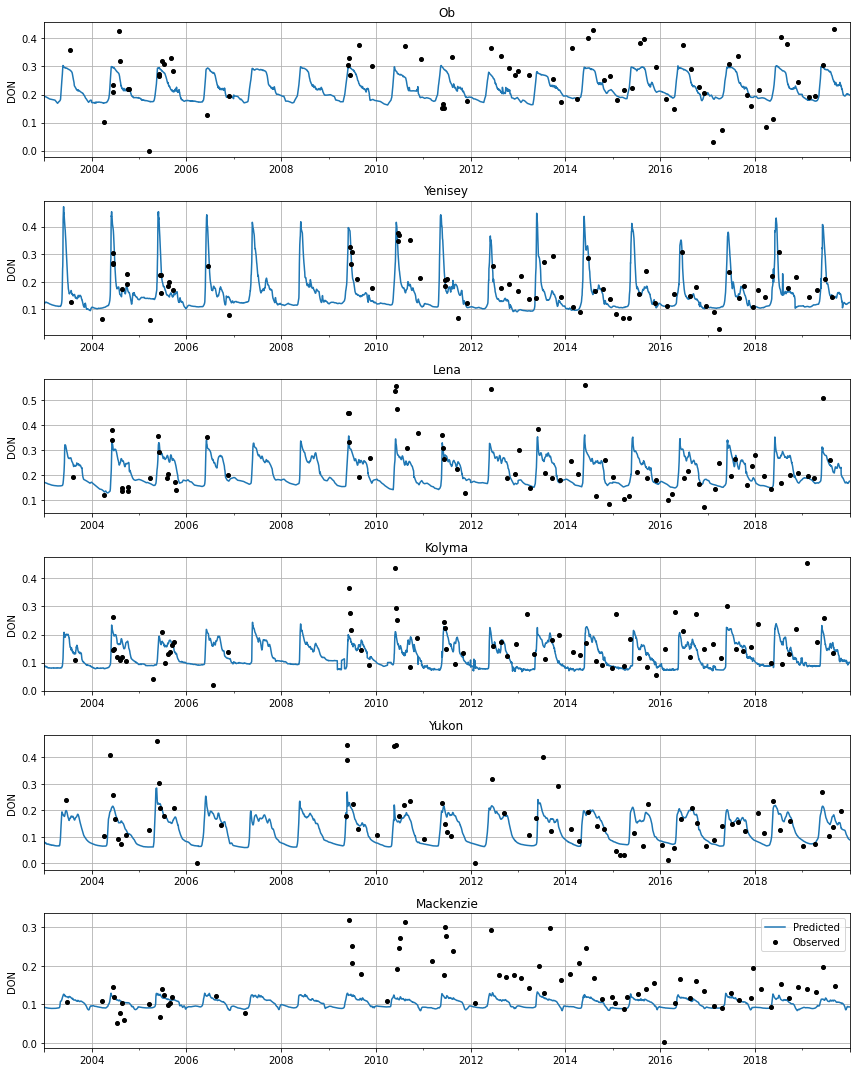

In [30]:
# Plot
for chem in chem_vars_doc_c:
    df = predicted_chem_daily_dict[chem]
    plot_predicted_obs_chem(df, chem, out_folder_predictions_timeseries_daily)

## Constant concentrations

P fractions show very weak relationships or scattered relationships with flow and DOC:
* PO4 is essentially constant across Q
* TDP has quality issues (step change at lots of rivers) which looks dodgy, and (perhaps partly because of this) a very poor relation with Q (-ve in the polluted Ob', slight positive elsewhere)
* Calculated DHP (~DOP) shows ~no relationships with DOC or Q

Therefore just set all to the long-term mean.

In [31]:
chem_vars_constant = ["PO4", "DHP"]

for var in chem_vars_constant:
    pred_li = []
    for river in rivers_li:
        mean_chem = chem_dict[river][var].mean()
        pred = pd.Series(index=q_dict[river].index, data=mean_chem)
        # Add to results
        pred.name = river
        pred_li.append(pred)

    # Make dataframe for this variable and save in dict and to file
    pred_df = pd.concat(pred_li, axis=1)
    predicted_chem_daily_dict[var] = pred_df
    pred_fpath = os.path.join(out_folder_predictions,
                              'daily', '%s.csv' % var)
    pred_df.to_csv(pred_fpath)

predicted_chem_daily_dict[var]

Ob   Yenisey      Lena   Kolyma     Yukon  Mackenzie
date                                                                  
1980-01-01  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
1980-01-02  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
1980-01-03  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
1980-01-04  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
1980-01-05  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
...              ...       ...       ...      ...       ...        ...
2019-12-27  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
2019-12-28  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
2019-12-29  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
2019-12-30  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766
2019-12-31  0.025563  0.003909  0.005776  0.00567  0.005176   0.002766

[14610 rows x 6 columns]

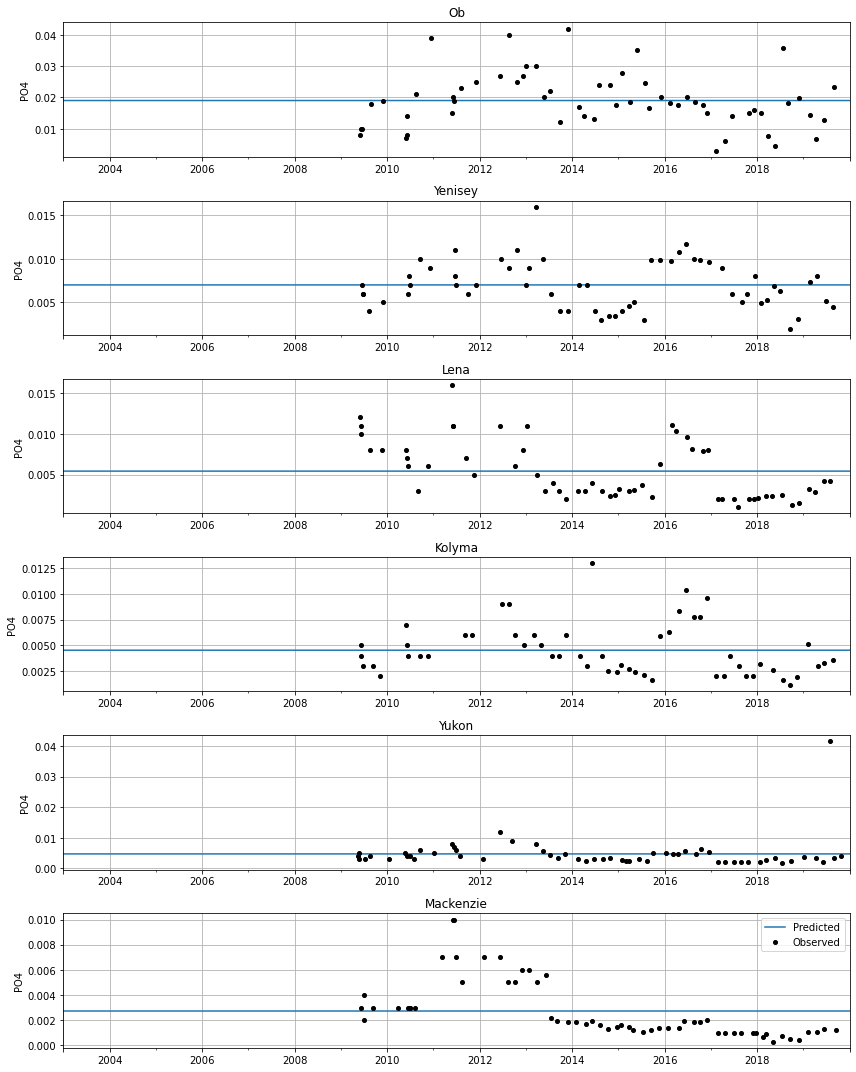

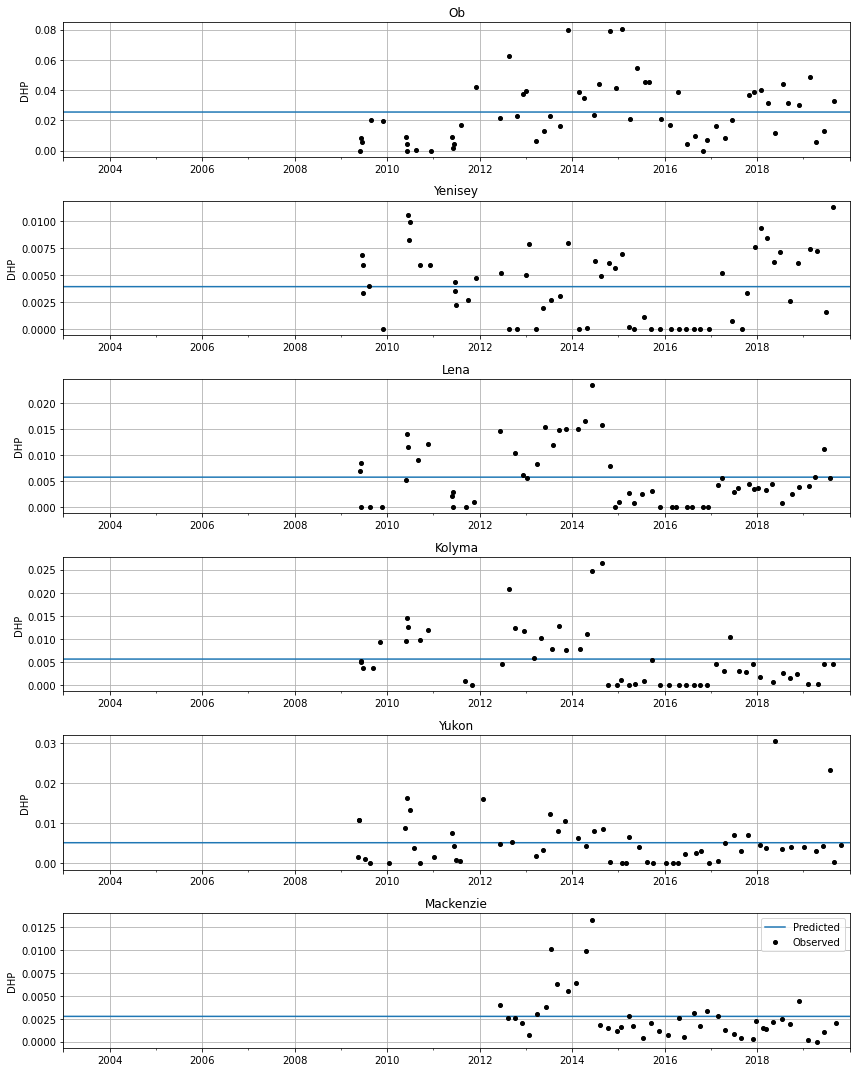

In [32]:
# Plot
for chem in chem_vars_constant:
    df = predicted_chem_daily_dict[chem]
    plot_predicted_obs_chem(df, chem, out_folder_predictions_timeseries_daily)

## Save all vars and rivers in one file too

In [33]:
# Combine daily predictions for all variables into one dataframe
pred_daily_allvars_df = pd.concat(predicted_chem_daily_dict)
pred_daily_allvars_df = pred_daily_allvars_df.reset_index()
pred_daily_allvars_df = pred_daily_allvars_df.rename({"level_0": "var"}, axis=1)

# Save
pred_daily_allvars_fpath = os.path.join(
    out_folder_predictions, "daily", "big6_chem_daily_all_vars.csv"
)
pred_daily_allvars_df.to_csv(pred_daily_allvars_fpath, index=False)

pred_daily_allvars_df

var       date         Ob    Yenisey       Lena     Kolyma  \
0       Alk 1980-01-01  83.675331  74.633441  68.584575  38.668375   
1       Alk 1980-01-02  83.729467  74.867041  68.584575  38.608134   
2       Alk 1980-01-03  83.729467  75.293371  68.723129  38.578490   
3       Alk 1980-01-04  83.892526  75.485307  68.723129  38.549078   
4       Alk 1980-01-05  84.056575  75.678844  68.723129  38.519894   
...     ...        ...        ...        ...        ...        ...   
175315  DHP 2019-12-27   0.025563   0.003909   0.005776   0.005670   
175316  DHP 2019-12-28   0.025563   0.003909   0.005776   0.005670   
175317  DHP 2019-12-29   0.025563   0.003909   0.005776   0.005670   
175318  DHP 2019-12-30   0.025563   0.003909   0.005776   0.005670   
175319  DHP 2019-12-31   0.025563   0.003909   0.005776   0.005670   

             Yukon   Mackenzie  
0       121.910336  108.650556  
1       121.910336  108.263366  
2       121.910336  107.763973  
3       121.910336  107.461077  
4       121.910336  107.702794  
...            ...         ...  
175315    0.005176    0.002766  
175316    0.005176    0.002766  
175317    0.005176    0.002766  
175318    0.005176    0.002766  
175319    0.005176    0.002766  

[175320 rows x 8 columns]

# Convert daily predicted chem to monthly mean

Could do a flow-weighted monthly mean. However, flow doesn't change THAT much within a month in these large rivers, and the predicted chemistry data is so uncertain anyway that it's probably not worth faffing with. Something to come back to in the future perhaps. If so, I found this code snippet for calculating weighted averages using dataframes which may be useful:

grouped = df.groupby('Date')

def wavg(group):
    d = group['value']
    w = group['wt']
    return (d * w).sum() / w.sum()

grouped.apply(wavg)

In [34]:
def reindex_fifteenth(df):
    """
    Reindex monthly time series to format yyyy-mm-15, as requested by marine
    modellers

    input: df, with datetime index at monthly frequency.
    returns: df, reindexed
    """
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = 15
    df['date'] = pd.to_datetime(df[['year', 'month', 'day']])
    df = df.set_index('date')
    df.drop(['day', 'month', 'year'], axis=1, inplace=True)

    return df

In [35]:
predicted_chem_monthly_dict = {}
for chem in predicted_chem_daily_dict.keys():
    daily_df = predicted_chem_daily_dict[chem]
    monthly_df = daily_df.resample('M').agg(np.mean)

    # Reindex using 15th day of each month, rather than last day
    monthly_df = reindex_fifteenth(monthly_df)

    predicted_chem_monthly_dict[chem] = monthly_df

    # Write to csv
    fpath = os.path.join(out_folder_predictions, 'monthly_mean', '%s.csv' % chem)
    monthly_df.to_csv(fpath)

print(predicted_chem_monthly_dict['Alk']['Yenisey'].head(5))

date
1980-01-15    73.506705
1980-02-15    71.626529
1980-03-15    73.740708
1980-04-15    73.292596
1980-05-15    58.723594
Name: Yenisey, dtype: float64


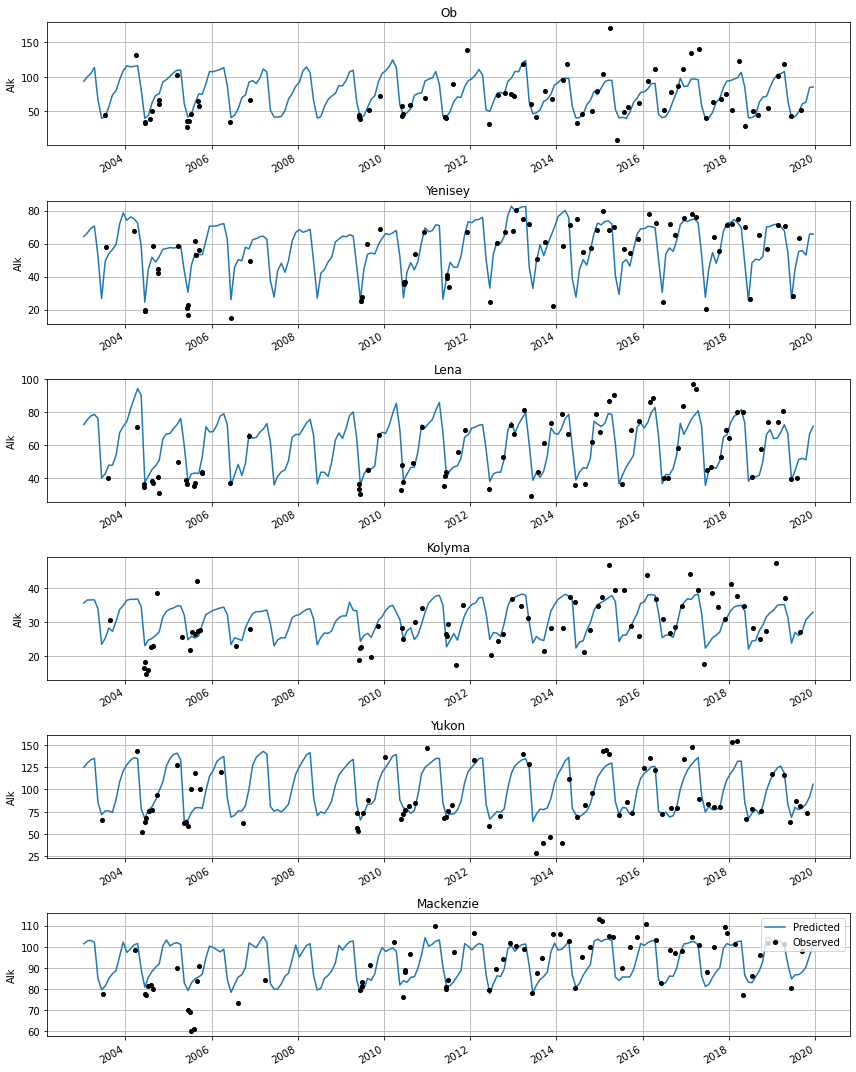

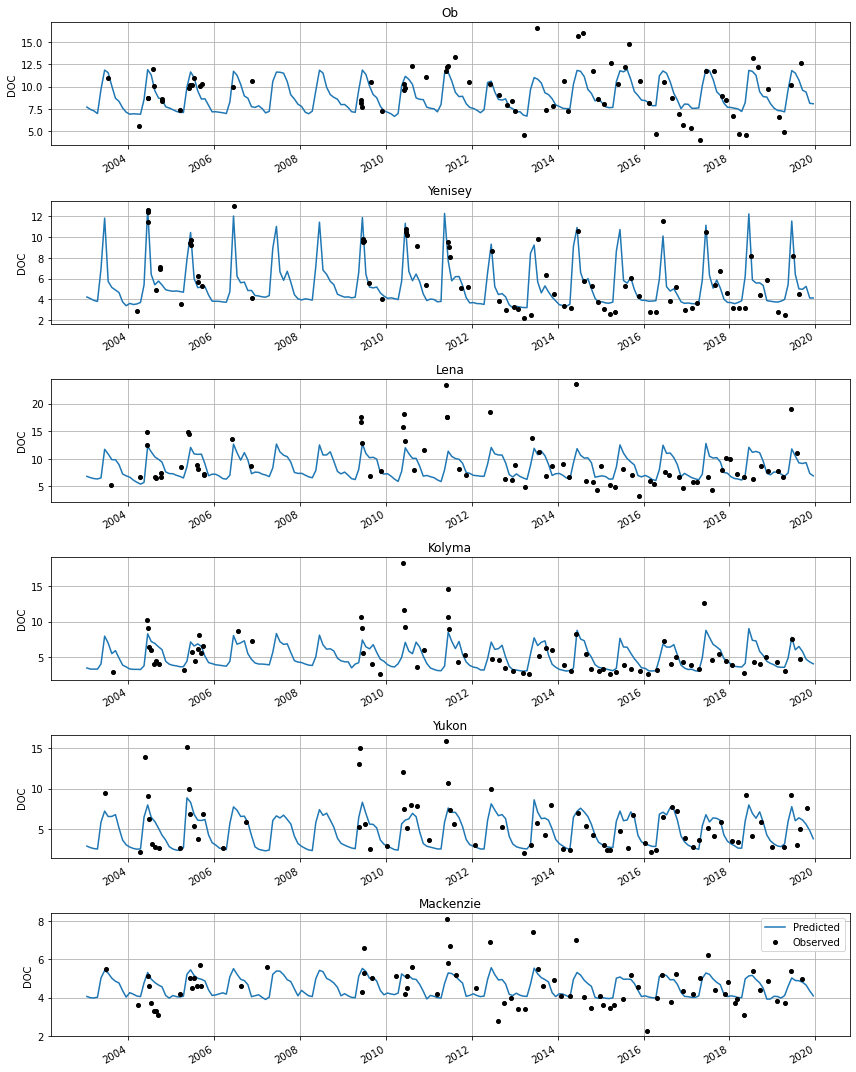

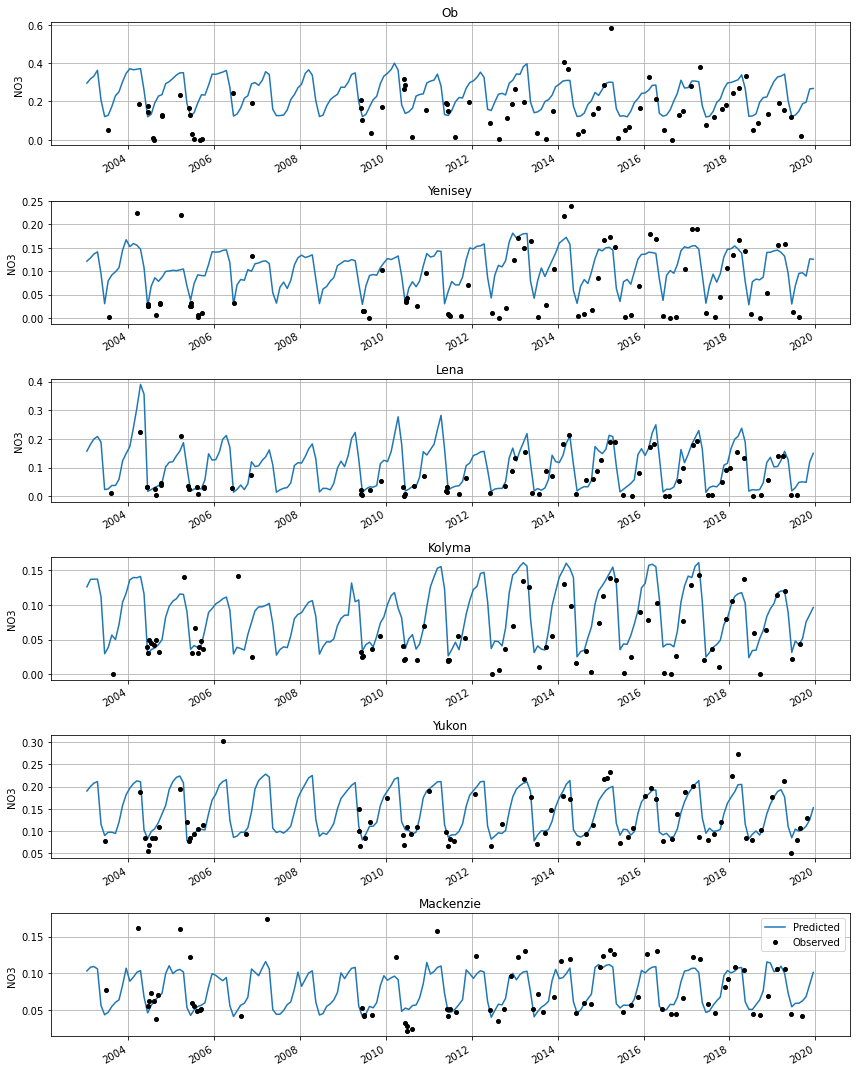

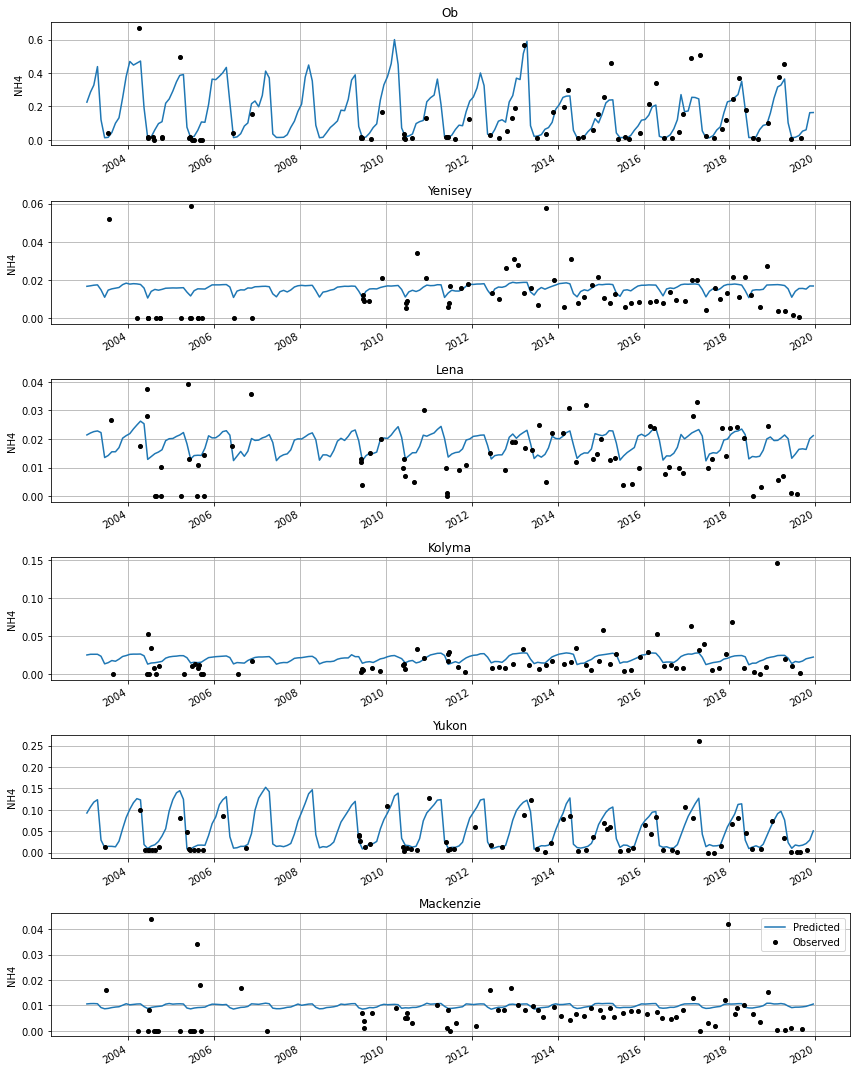

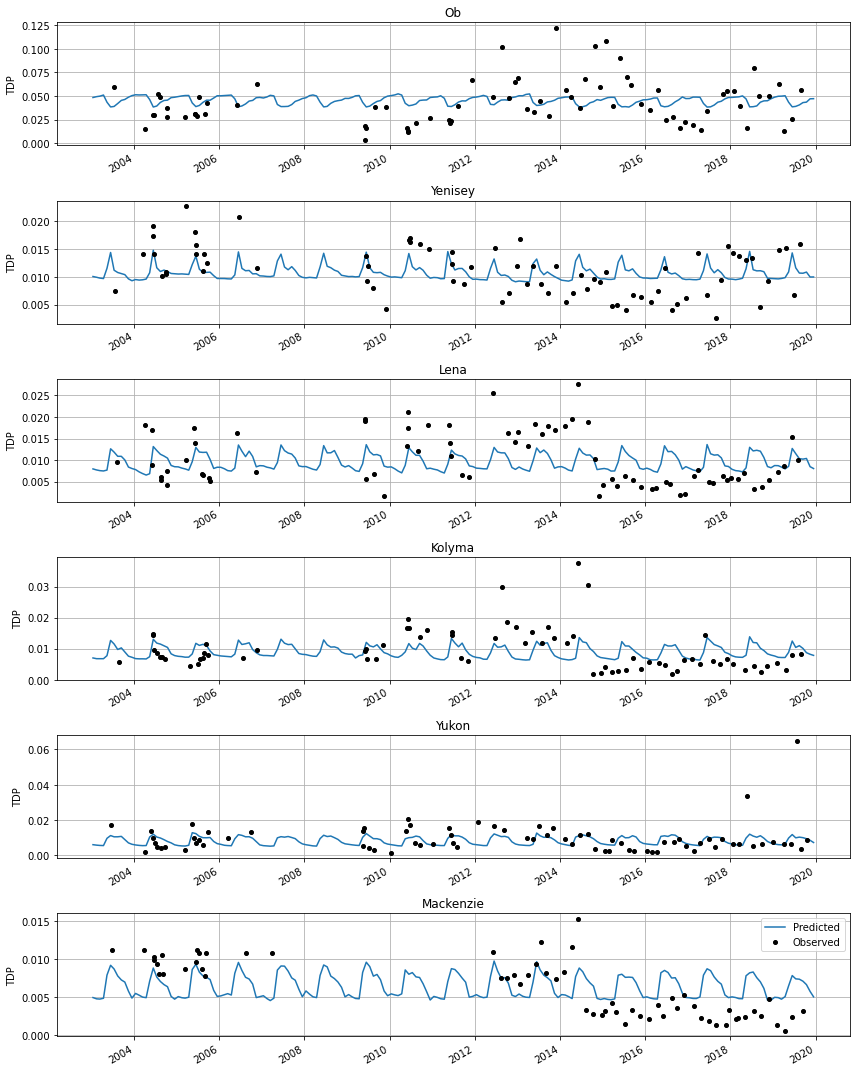

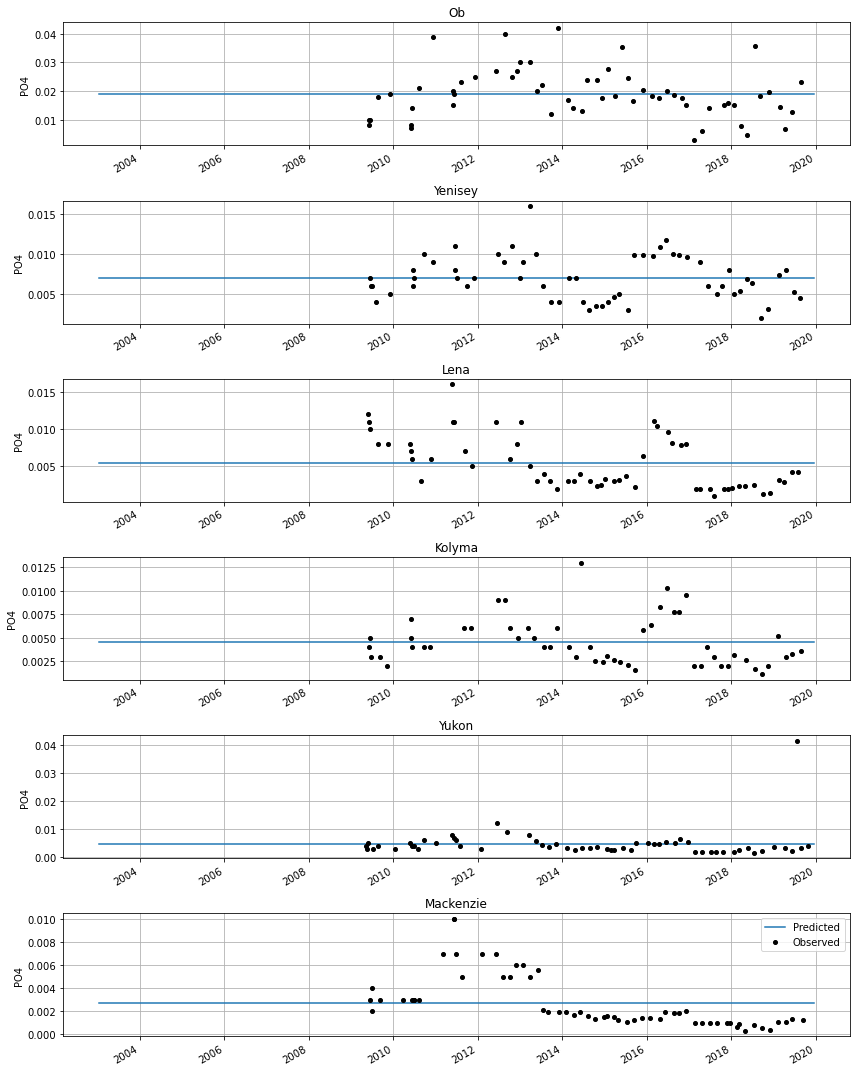

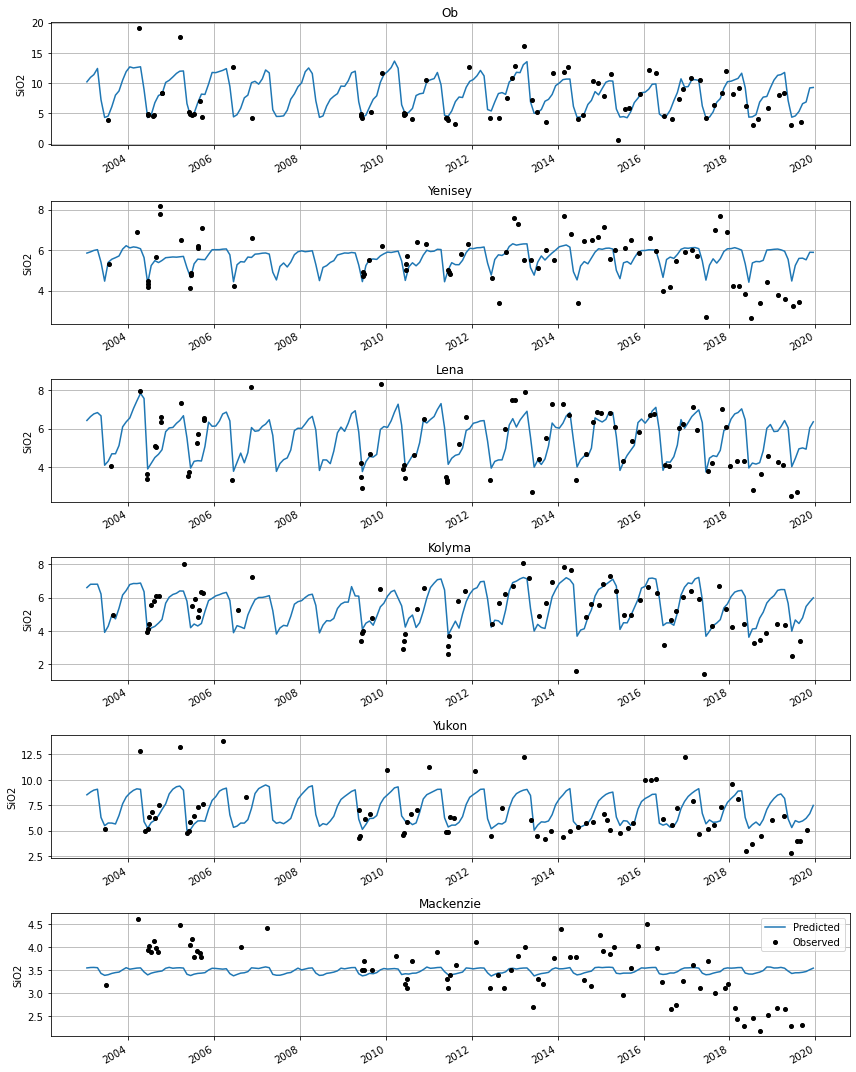

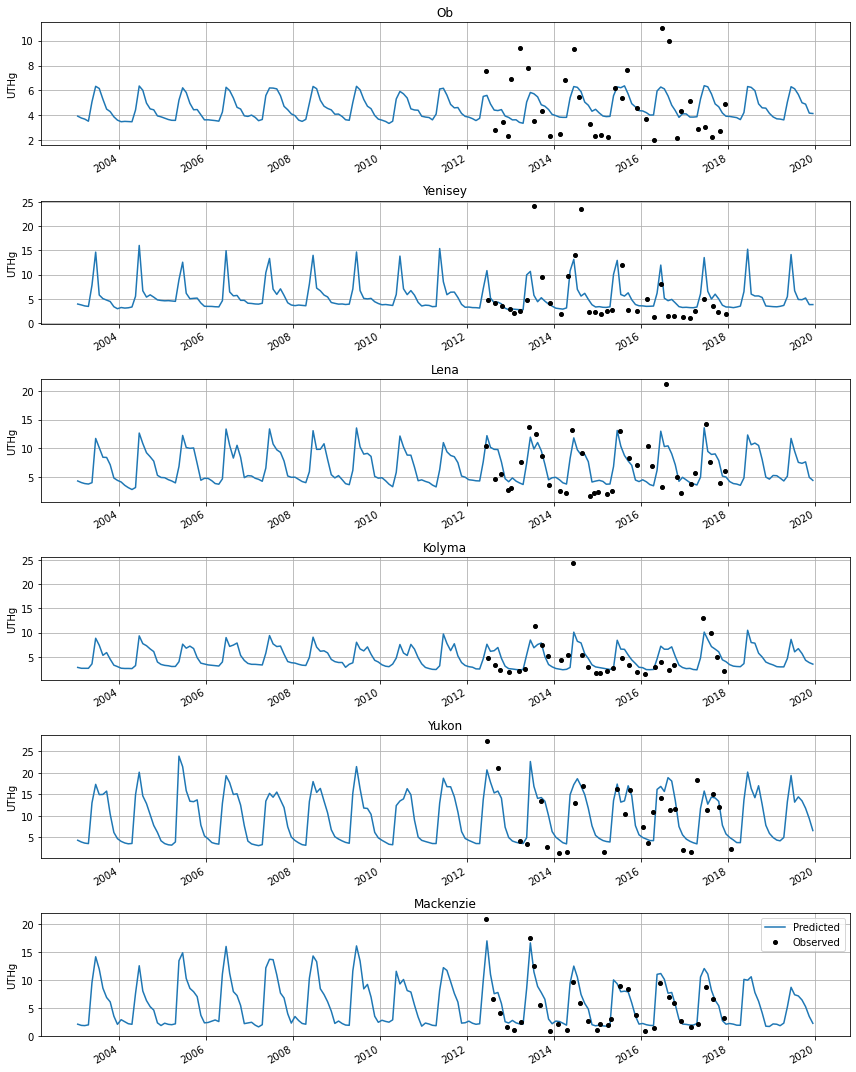

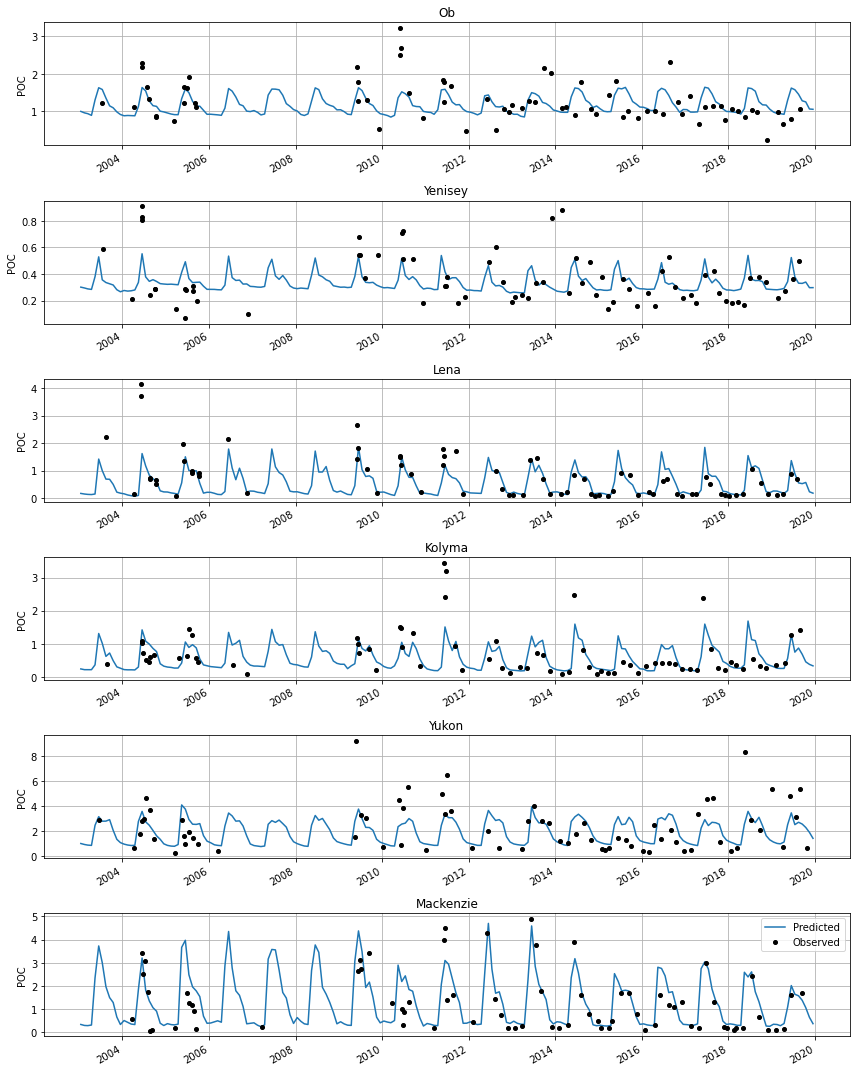

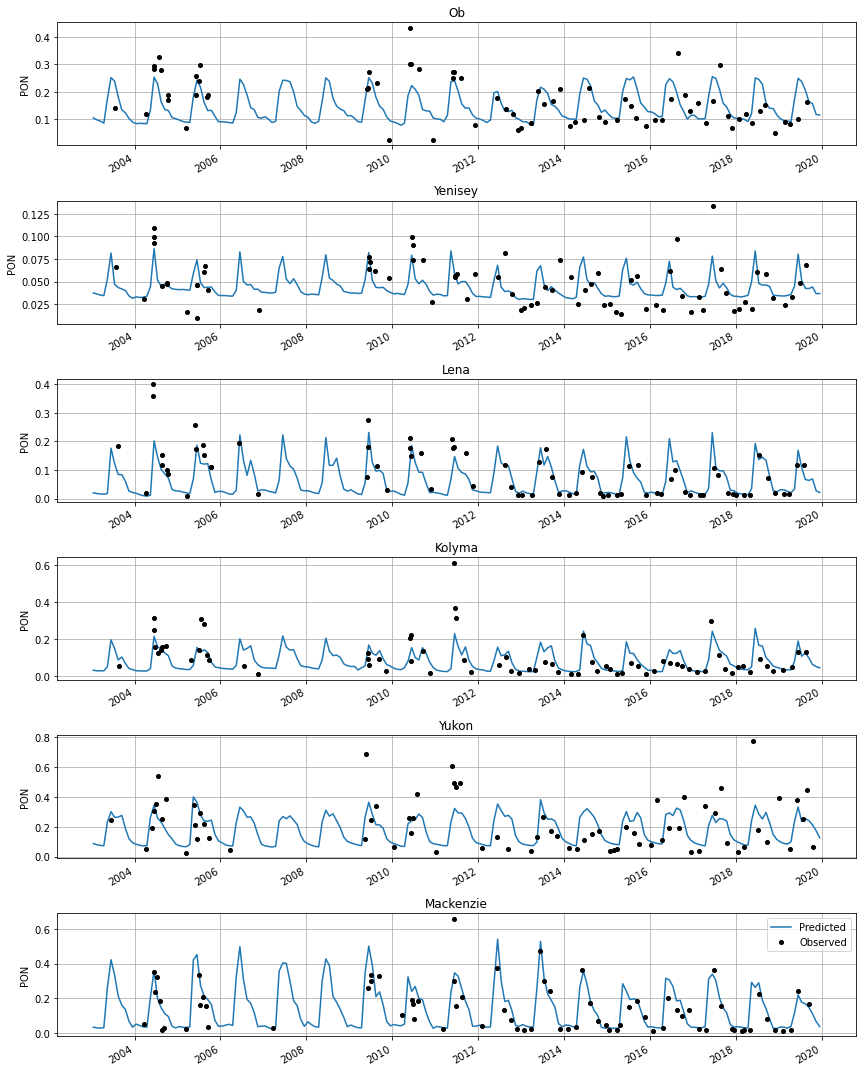

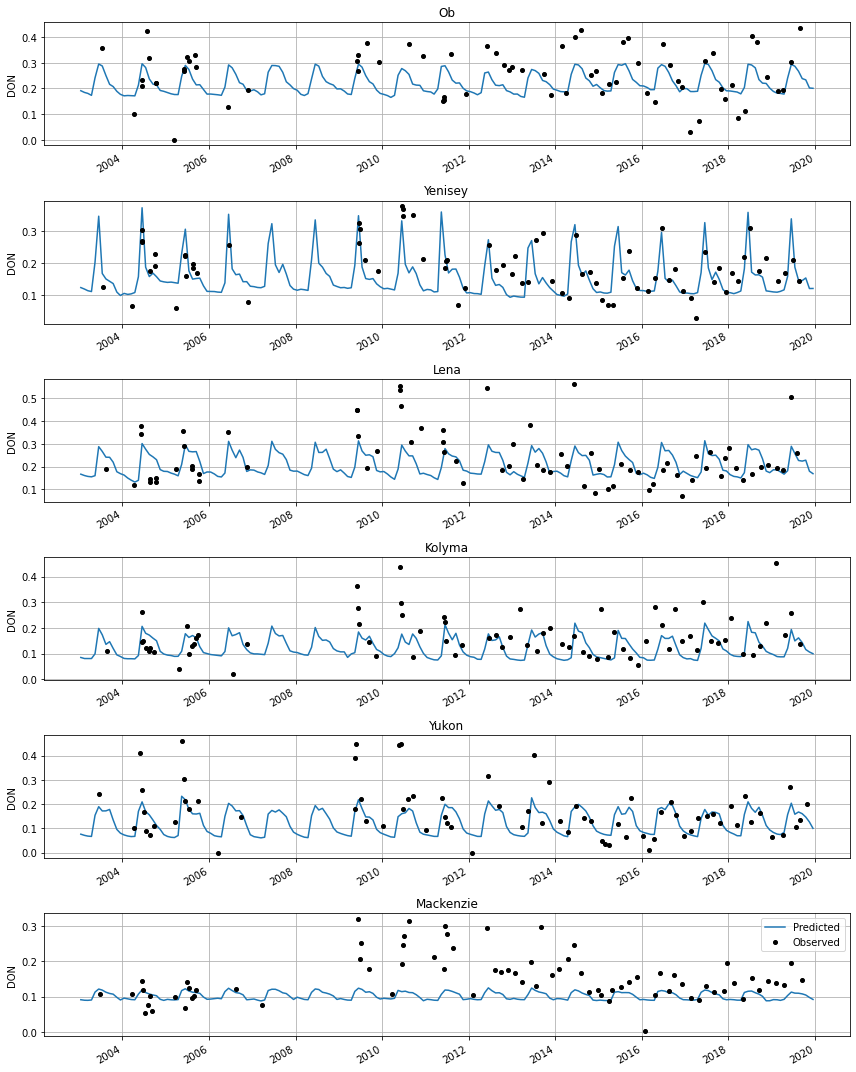

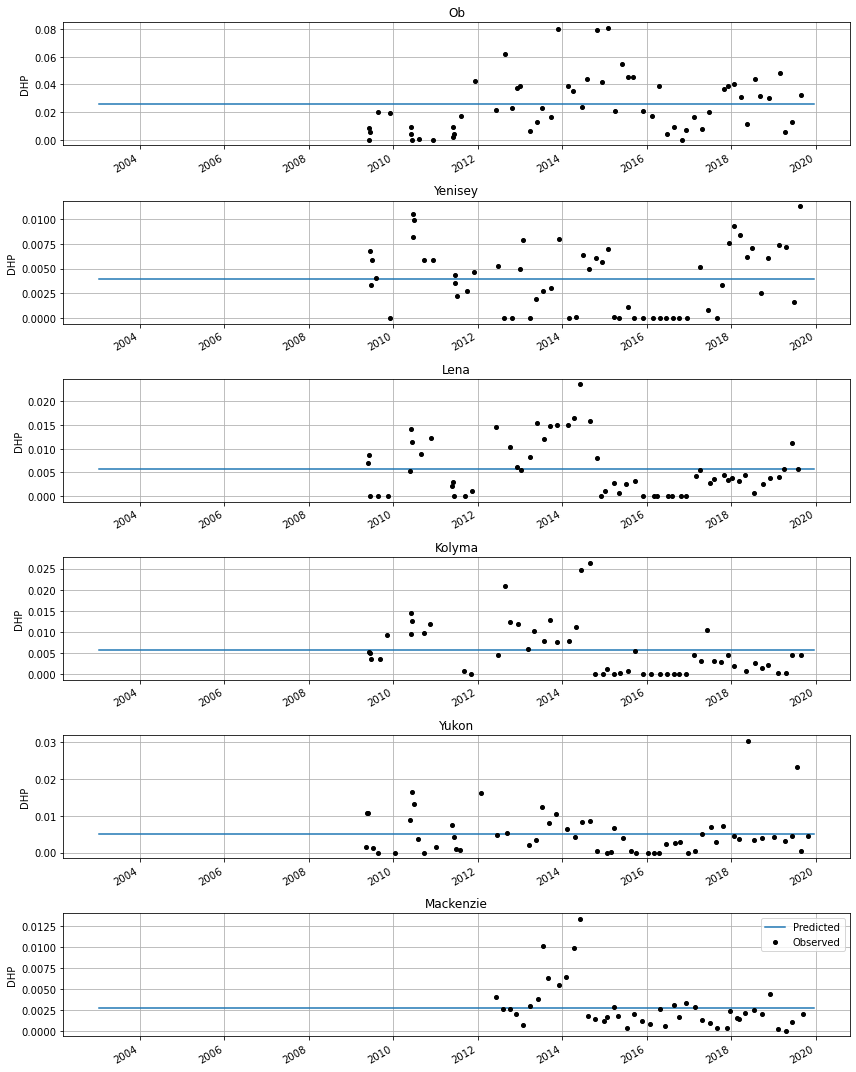

In [36]:
# Plot monthly mean vs daily observed
for chem in predicted_chem_monthly_dict.keys():
    df = predicted_chem_monthly_dict[chem]
    plot_predicted_obs_chem(df, chem, out_folder_predictions_timeseries_monthly)

In [37]:
# Combine monthly predictions for all variables into one dataframe
pred_monthly_allvars_df = pd.concat(predicted_chem_monthly_dict)
pred_monthly_allvars_df = pred_monthly_allvars_df.reset_index()
pred_monthly_allvars_df = pred_monthly_allvars_df.rename({"level_0": "var"}, axis=1)

# Save
pred_monthly_allvars_fpath = os.path.join(
    out_folder_predictions, "monthly_mean", "big6_chem_monthly_all_vars.csv"
)
pred_monthly_allvars_df.to_csv(pred_monthly_allvars_fpath, index=False)

pred_monthly_allvars_df

var       date          Ob    Yenisey       Lena     Kolyma       Yukon  \
0     Alk 1980-01-15   86.168092  73.506705  70.543926  38.493606  123.124748   
1     Alk 1980-02-15   97.528291  71.626529  76.188483  39.155371  126.727811   
2     Alk 1980-03-15  108.461093  73.740708  81.885121  36.520208  129.266343   
3     Alk 1980-04-15  114.014545  73.292596  85.974121  37.154305  133.122170   
4     Alk 1980-05-15   64.006869  58.723594  79.462673  37.313269   86.987030   
...   ...        ...         ...        ...        ...        ...         ...   
5755  DHP 2019-08-15    0.025563   0.003909   0.005776   0.005670    0.005176   
5756  DHP 2019-09-15    0.025563   0.003909   0.005776   0.005670    0.005176   
5757  DHP 2019-10-15    0.025563   0.003909   0.005776   0.005670    0.005176   
5758  DHP 2019-11-15    0.025563   0.003909   0.005776   0.005670    0.005176   
5759  DHP 2019-12-15    0.025563   0.003909   0.005776   0.005670    0.005176   

       Mackenzie  
0     105.271944  
1     105.575989  
2     106.472178  
3     106.773701  
4      88.055871  
...          ...  
5755    0.002766  
5756    0.002766  
5757    0.002766  
5758    0.002766  
5759    0.002766  

[5760 rows x 8 columns]